In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal.ltisys import TransferFunctionContinuous
import sympy as sym
from IPython.display import display
import seaborn as sns
from decimal import Decimal

%matplotlib inline
%config InlineBackend.figure_format = "retina"
sns.set_theme(context="notebook", style="whitegrid", palette="colorblind", color_codes=True, \
              rc={"figure.figsize": (8.27,11.69/2), "text.usetex": False, 'font.family': 'STIXGeneral',\
                    'axes.linewidth': 0.65, 'mathtext.fontset': 'stix', 'axes.edgecolor': '0',\
                     'axes.xmargin': 0, 'axes.ymargin': 0})

In [2]:
class ParallelModel(TransferFunctionContinuous):
    def __init__(self, **params):
        self.setParams(**params)
    
    def setParams(self, **params):
        self.n_Rc = params['Rc'] # Normally 0.25
        self.n_R1 = params['R1'] # Normally = 5.5
        self.n_R2 = params['R2'] # Normally = 5.5
        self.n_E1 = params['E1'] # Normally 20
        self.n_E2 = params['E2'] # Normally 20
        n = [self.n_R1 + self.n_R2, self.n_E1 + self.n_E2]
        d = [self.n_R1 * self.n_R2 + self.n_Rc * (self.n_R1 + self.n_R2),
                         (self.n_R2 + self.n_Rc) * self.n_E1 + (self.n_R1 + self.n_Rc)*self.n_E2,
                          self.n_E1 * self.n_E2]
        super().__init__(d, n)


class BharatModel(TransferFunctionContinuous):
    def __init__(self, impedance=True, **params):
        self.impedance = impedance # if return Z (impedance) or H (transfer_function)
        self.μ = 1.8e-5 # dynamic viscosity of air
        self.ρ = 1.293 # kg/m**3 density of air
        δ1 = 2.4048
        self.λq = 1/δ1**2
        self.λp = 1/δ1**2*(1 - 32/δ1**4)
        try:
          if params['steady']: self.λq = self.λp = 1
        except KeyError: pass
        self.setParams(**params)
        
    def getRs(self, gen, branch):
        if gen not in [0, 1]: raise ValueError("gen must be either 0 or 1")
        if branch == '1':
          hL = self.h1L
          hD = self.h1D
        elif branch == '2':
          hL = self.h2L
          hD = self.h2D
        else: raise ValueError("branch value must be either '1' or '2'")
        Rs2 = (self.A1*self.L0*hL**gen)/((self.D0*hD**gen)**4) + self.Rd1*gen
        Rs1 = Rs2*(self.λq/self.λp - 1) + self.Rd2*gen
        return({"Rs1": Rs1, "Rs2": Rs2})

    def setParams(self, **params):
        self.D0 = params['D0']
        self.L0 = params['L0']
        self.h1D = params['h1D']
        self.h2D = params['h2D']
        self.h1L = params['h1L']
        self.h2L = params['h2L']
        self.C1 = params['C1'] 
        self.C2 = params['C2']
        self.Rd1 = params['Rd1']
        self.Rd2 = params['Rd2']
        A1, A2, λq, λp, s = sym.symbols('A_1 A_2 λ_q λ_p s', constant=True)
        D0, L0, h1D, h2D, h1L, h2L, C1, C2, Rd1, Rd2 = sym.symbols('D_0 L_0 h_1D h_2D h_1L h_2L C_1 C_2 Rd1 Rd2')
        self.A1 = 128*self.μ/np.pi
        self.A2 = 4*self.μ/(self.λq*self.ρ)

        try:
          self.n = params['n']
          self.d = params['d']
        except KeyError:
          Z0 = A1*L0/D0**4*(λq + A2/(s*D0**2))/(λp + A2/(s*D0**2))
          Z1 = A1*h1L*L0/((h1D*D0)**4)*(λq + A2/(s*(h1D*D0)**2))/(λp + A2/(s*(h1D*D0)**2)) + 1/(s*C1) + Rd1
          Z2 = A1*h2L*L0/((h2D*D0)**4)*(λq + A2/(s*(h2D*D0)**2))/(λp + A2/(s*(h2D*D0)**2)) + 1/(s*C2) + Rd2
          Z_par = Z0 + Z1*Z2/(Z1+Z2)
          n, d = sym.fraction(sym.factor(Z_par))
          self.n = sym.collect(sym.expand(n), s, evaluate=False)
          self.d = sym.collect(sym.expand(d), s, evaluate=False)
        n_list = [self.n[s**5], self.n[s**4], self.n[s**3], self.n[s**2], self.n[s], self.n[1]]
        n_list = [expr.subs({A1: self.A1, A2: self.A2, λq: self.λq, λp: self.λp,\
                              h1L: self.h1L, h2L: self.h2L, h1D: self.h1D, h2D: self.h2D,\
                              D0: self.D0, L0: self.L0, C1: self.C1, C2: self.C2,\
                              Rd1: self.Rd1, Rd2: self.Rd2}) for expr in n_list]
        n_list = [float(expr.subs({s:1}).evalf()) for expr in n_list]
        d_list = [self.d[s**5], self.d[s**4], self.d[s**3], self.d[s**2], self.d[s]]
        d_list = [expr.subs({A1: self.A1, A2: self.A2, λq: self.λq, λp: self.λp,\
                              h1L: self.h1L, h2L: self.h2L, h1D: self.h1D, h2D: self.h2D,\
                              D0: self.D0, L0: self.L0, C1: self.C1, C2: self.C2,\
                              Rd1: self.Rd1, Rd2: self.Rd2}) for expr in d_list]
        d_list = [float(expr.subs({s:1}).evalf()) for expr in d_list]
        if self.impedance: super().__init__(n_list, d_list)
        else: super().__init__(d_list, n_list)

In [3]:
A1, A2, λq, λp, s = sym.symbols('A_1 A_2 λ_q λ_p s', constant=True)
D0, L0, h1D, h2D, h1L, h2L, C1, C2, Rd1, Rd2 = sym.symbols('D_0 L_0 h_1D h_2D h_1L h_2L C_1 C_2 Rd1 Rd2')
Z0 = A1*L0/D0**4*(λq + A2/(s*D0**2))/(λp + A2/(s*D0**2))
Z1 = A1*h1L*L0/((h1D*D0)**4)*(λq + A2/(s*(h1D*D0)**2))/(λp + A2/(s*(h1D*D0)**2)) + 1/(s*C1) + Rd1
Z2 = A1*h2L*L0/((h2D*D0)**4)*(λq + A2/(s*(h2D*D0)**2))/(λp + A2/(s*(h2D*D0)**2)) + 1/(s*C2) + Rd2
Z_eq = Z0 + Z1*Z2/(Z1+Z2)
n, d = sym.fraction(sym.factor(Z_eq))
n = sym.collect(sym.expand(n), s, evaluate=False)
d = sym.collect(sym.expand(d), s, evaluate=False)
display(Z0)
display(Z1)
display(Z2)
display(Z_eq)

A_1*L_0*(A_2/(D_0**2*s) + λ_q)/(D_0**4*(A_2/(D_0**2*s) + λ_p))

A_1*L_0*h_1L*(A_2/(D_0**2*h_1D**2*s) + λ_q)/(D_0**4*h_1D**4*(A_2/(D_0**2*h_1D**2*s) + λ_p)) + Rd1 + 1/(C_1*s)

A_1*L_0*h_2L*(A_2/(D_0**2*h_2D**2*s) + λ_q)/(D_0**4*h_2D**4*(A_2/(D_0**2*h_2D**2*s) + λ_p)) + Rd2 + 1/(C_2*s)

A_1*L_0*(A_2/(D_0**2*s) + λ_q)/(D_0**4*(A_2/(D_0**2*s) + λ_p)) + (A_1*L_0*h_1L*(A_2/(D_0**2*h_1D**2*s) + λ_q)/(D_0**4*h_1D**4*(A_2/(D_0**2*h_1D**2*s) + λ_p)) + Rd1 + 1/(C_1*s))*(A_1*L_0*h_2L*(A_2/(D_0**2*h_2D**2*s) + λ_q)/(D_0**4*h_2D**4*(A_2/(D_0**2*h_2D**2*s) + λ_p)) + Rd2 + 1/(C_2*s))/(A_1*L_0*h_2L*(A_2/(D_0**2*h_2D**2*s) + λ_q)/(D_0**4*h_2D**4*(A_2/(D_0**2*h_2D**2*s) + λ_p)) + A_1*L_0*h_1L*(A_2/(D_0**2*h_1D**2*s) + λ_q)/(D_0**4*h_1D**4*(A_2/(D_0**2*h_1D**2*s) + λ_p)) + Rd1 + Rd2 + 1/(C_2*s) + 1/(C_1*s))

In [4]:
inertia1 = BharatModel(D0=0.02, L0=0.1, h1L=2**(1/2), h2L=2**(1/2), h1D= 2**(1/4), h2D=2**(1/4), C1=1/1256, C2=1/1256, Rd1=50000, Rd2=50000, n=n, d=d) #check Schmidtt for C1 and C2
steady1 = BharatModel(D0=0.02, L0=0.1, h1L=2**(1/3), h2L=2**(1/3), h1D= 2**(1/3), h2D=2**(1/3), C1=inertia1.C1, C2=inertia1.C2, Rd1=inertia1.Rd1, Rd2=inertia1.Rd2, n=n, d=d, steady=True)
parallel1 = ParallelModel(Rc=inertia1.getRs(0,'1')["Rs2"], R1=inertia1.getRs(1,'1')["Rs2"], R2=inertia1.getRs(1,'2')["Rs2"], E1=1/inertia1.C1, E2=1/inertia1.C2)

inertia2 = BharatModel(D0=0.02, L0=0.1, h1L=2**(1/2), h2L=2**(1/2), h1D= 2**(1/4), h2D=2**(1/4), C1=1/1256, C2=1/1256, Rd1=100000, Rd2=50000, n=n, d=d) #check Schmidtt for C1 and C2
steady2 = BharatModel(D0=0.02, L0=0.1, h1L=2**(1/3), h2L=2**(1/3), h1D= 2**(1/3), h2D=2**(1/3), C1=inertia2.C1, C2=inertia2.C2, Rd1=inertia2.Rd1, Rd2=inertia2.Rd2, n=n, d=d, steady=True)
parallel2 = ParallelModel(Rc=inertia2.getRs(0,'1')["Rs2"], R1=inertia2.getRs(1,'1')["Rs2"], R2=inertia2.getRs(1,'2')["Rs2"], E1=1/inertia2.C1, E2=1/inertia2.C2)

inertia3 = BharatModel(D0=0.02, L0=0.1, h1L=2**(1/2), h2L=2**(1/2), h1D= 2**(1/4), h2D=2**(1/4), C1=1/2512, C2=1/2512, Rd1=50000, Rd2=50000, n=n, d=d) #check Schmidtt for C1 and C2
steady3 = BharatModel(D0=0.02, L0=0.1, h1L=2**(1/3), h2L=2**(1/3), h1D= 2**(1/3), h2D=2**(1/3), C1=inertia3.C1, C2=inertia3.C2, Rd1=inertia3.Rd1, Rd2=inertia3.Rd2, n=n, d=d, steady=True)
parallel3 = ParallelModel(Rc=inertia3.getRs(0,'1')["Rs2"], R1=inertia3.getRs(1,'1')["Rs2"], R2=inertia3.getRs(1,'2')["Rs2"], E1=1/inertia3.C1, E2=1/inertia3.C2)

inertia4 = BharatModel(D0=0.02, L0=0.1, h1L=2**(1/2), h2L=2**(1/2), h1D= 0.5*2**(1/4), h2D=2**(1/4), C1=1/1256, C2=1/1256, Rd1=50000, Rd2=50000, n=n, d=d) #check Schmidtt for C1 and C2
steady4 = BharatModel(D0=0.02, L0=0.1, h1L=2**(1/3), h2L=2**(1/3), h1D= 0.5*2**(1/3), h2D=2**(1/3), C1=inertia4.C1, C2=inertia4.C2, Rd1=inertia4.Rd1, Rd2=inertia4.Rd2, n=n, d=d, steady=True)
parallel4 = ParallelModel(Rc=inertia4.getRs(0,'1')["Rs2"], R1=inertia4.getRs(1,'1')["Rs2"], R2=inertia4.getRs(1,'2')["Rs2"], E1=1/inertia4.C1, E2=1/inertia4.C2)


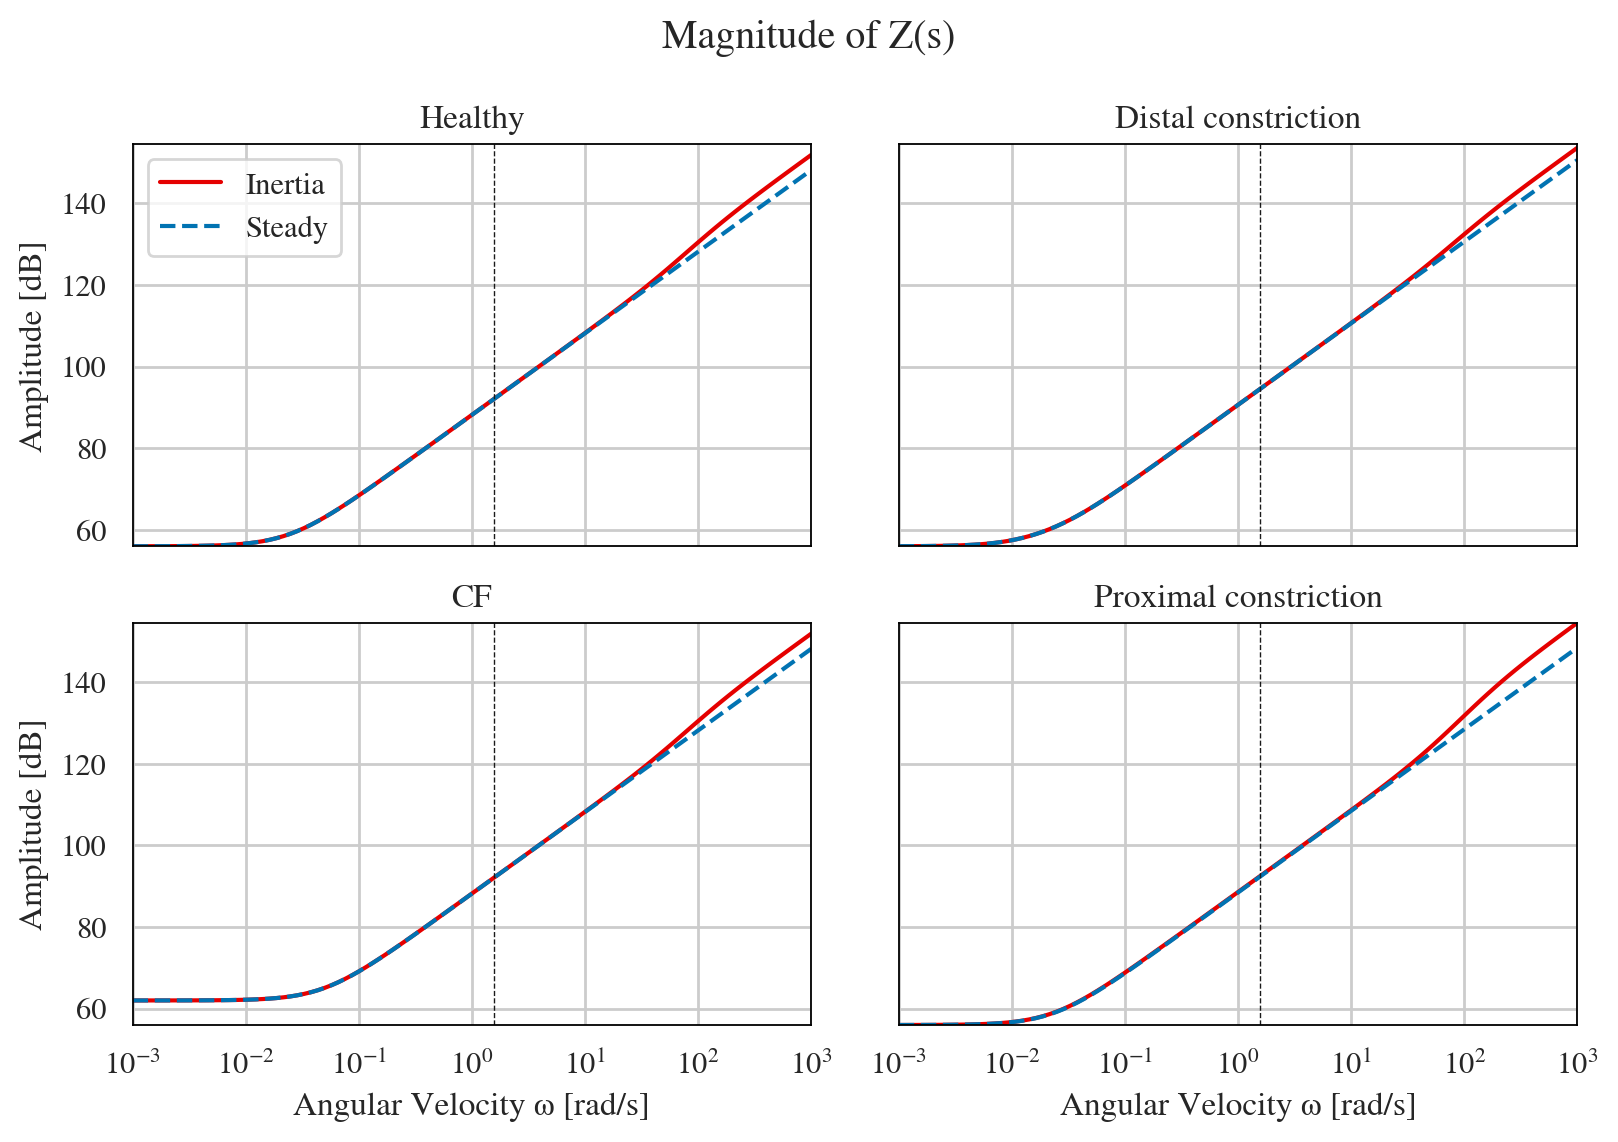

In [5]:
w, mag_inertia1, phase_inertia1 = inertia1.bode()
w, mag_steady1, phase_steady1 = steady1.bode(w=w)
real_inertia1 = mag_inertia1 * np.cos(np.deg2rad(phase_inertia1))
imaginary_inertia1 = mag_inertia1 * np.sin(np.deg2rad(phase_inertia1))
real_steady1 = mag_inertia1 * np.cos(np.deg2rad(phase_steady1))
imaginary_steady1 = mag_inertia1 * np.sin(np.deg2rad(phase_steady1))

w, mag_inertia2, phase_inertia2 = inertia2.bode(w=w)
w, mag_steady2, phase_steady2 = steady2.bode(w=w)
real_inertia2 = mag_inertia2 * np.cos(np.deg2rad(phase_inertia2))
imaginary_inertia2 = mag_inertia2 * np.sin(np.deg2rad(phase_inertia2))
real_steady2 = mag_inertia2 * np.cos(np.deg2rad(phase_steady2))
imaginary_steady2 = mag_inertia2 * np.sin(np.deg2rad(phase_steady2))

w, mag_inertia3, phase_inertia3 = inertia3.bode(w=w)
w, mag_steady3, phase_steady3 = steady3.bode(w=w)
real_inertia3 = mag_inertia3 * np.cos(np.deg2rad(phase_inertia3))
imaginary_inertia3 = mag_inertia3 * np.sin(np.deg2rad(phase_inertia3))
real_steady3 = mag_inertia3 * np.cos(np.deg2rad(phase_steady3))
imaginary_steady3 = mag_inertia3 * np.sin(np.deg2rad(phase_steady3))

w, mag_inertia4, phase_inertia4 = inertia4.bode(w=w)
w, mag_steady4, phase_steady4 = steady4.bode(w=w)
real_inertia4 = mag_inertia4 * np.cos(np.deg2rad(phase_inertia4))
imaginary_inertia4 = mag_inertia4 * np.sin(np.deg2rad(phase_inertia4))
real_steady4 = mag_inertia4 * np.cos(np.deg2rad(phase_steady4))
imaginary_steady4 = mag_inertia4 * np.sin(np.deg2rad(phase_steady4))

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax[0, 0].semilogx(w, mag_inertia1, label="Inertia", color='#E50000')
ax[0, 0].semilogx(w, mag_steady1, label="Steady", color="b", linestyle="--")
ax[0, 0].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[0, 0].set_title("Healthy")

ax[0, 1].semilogx(w, mag_inertia2, label="Inertia", color='#E50000')
ax[0, 1].semilogx(w, mag_steady2, label="Steady", color="b", linestyle="--")
ax[0, 1].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[0, 1].set_title("Distal constriction")

ax[1, 0].semilogx(w, mag_inertia3, label="Inertia", color='#E50000')
ax[1, 0].semilogx(w, mag_steady3, label="Steady", color="b", linestyle="--")
ax[1, 0].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[1, 0].set_title("CF")

ax[1, 1].semilogx(w, mag_inertia4, label="Inertia", color='#E50000')
ax[1, 1].semilogx(w, mag_steady4, label="Steady", color="b", linestyle="--")
ax[1, 1].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[1, 1].set_title("Proximal constriction")

ax[1, 0].set_xlabel("Angular Velocity ω [rad/s]")
ax[1, 1].set_xlabel("Angular Velocity ω [rad/s]")
ax[0, 0].set_ylabel("Amplitude [dB]")
ax[1, 0].set_ylabel("Amplitude [dB]")
ax[0, 0].legend()
plt.suptitle("Magnitude of Z(s)")
plt.tight_layout()
plt.show()

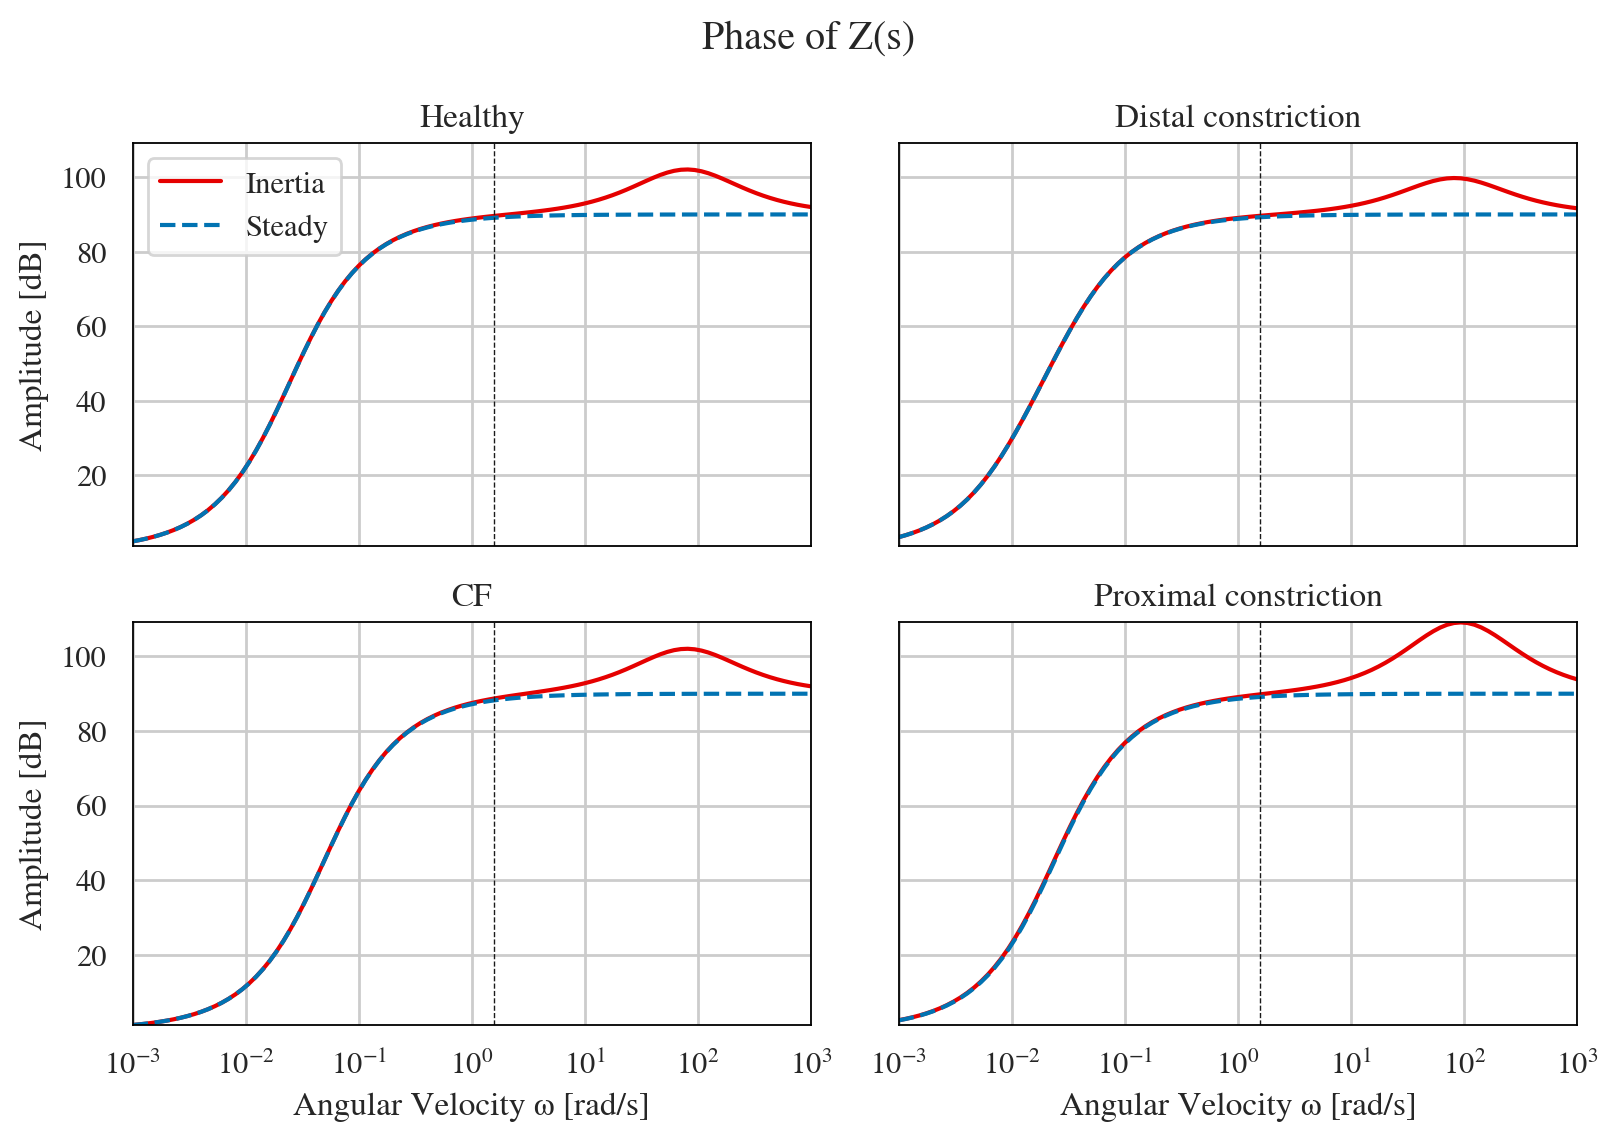

In [6]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax[0, 0].semilogx(w, phase_inertia1, label="Inertia", color='#E50000')
ax[0, 0].semilogx(w, phase_steady1, label="Steady", color="b", linestyle="--")

ax[0, 0].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[0, 0].set_title("Healthy")
ax[0, 1].semilogx(w, phase_inertia2, label="Inertia", color='#E50000')
ax[0, 1].semilogx(w, phase_steady2, label="Steady", color="b", linestyle="--")

ax[0, 1].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[0, 1].set_title("Distal constriction")
ax[1, 0].semilogx(w, phase_inertia3, label="Inertia", color='#E50000')
ax[1, 0].semilogx(w, phase_steady3, label="Steady", color="b", linestyle="--")

ax[1, 0].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[1, 0].set_title("CF")
ax[1, 1].semilogx(w, phase_inertia4, label="Inertia", color='#E50000')
ax[1, 1].semilogx(w, phase_steady4, label="Steady", color="b", linestyle="--")

ax[1, 1].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[1, 1].set_title("Proximal constriction")

ax[1, 0].set_xlabel("Angular Velocity ω [rad/s]")
ax[1, 1].set_xlabel("Angular Velocity ω [rad/s]")
ax[0, 0].set_ylabel("Amplitude [dB]")
ax[1, 0].set_ylabel("Amplitude [dB]")

ax[0, 0].legend()
plt.suptitle("Phase of Z(s)")
plt.tight_layout()
plt.show()

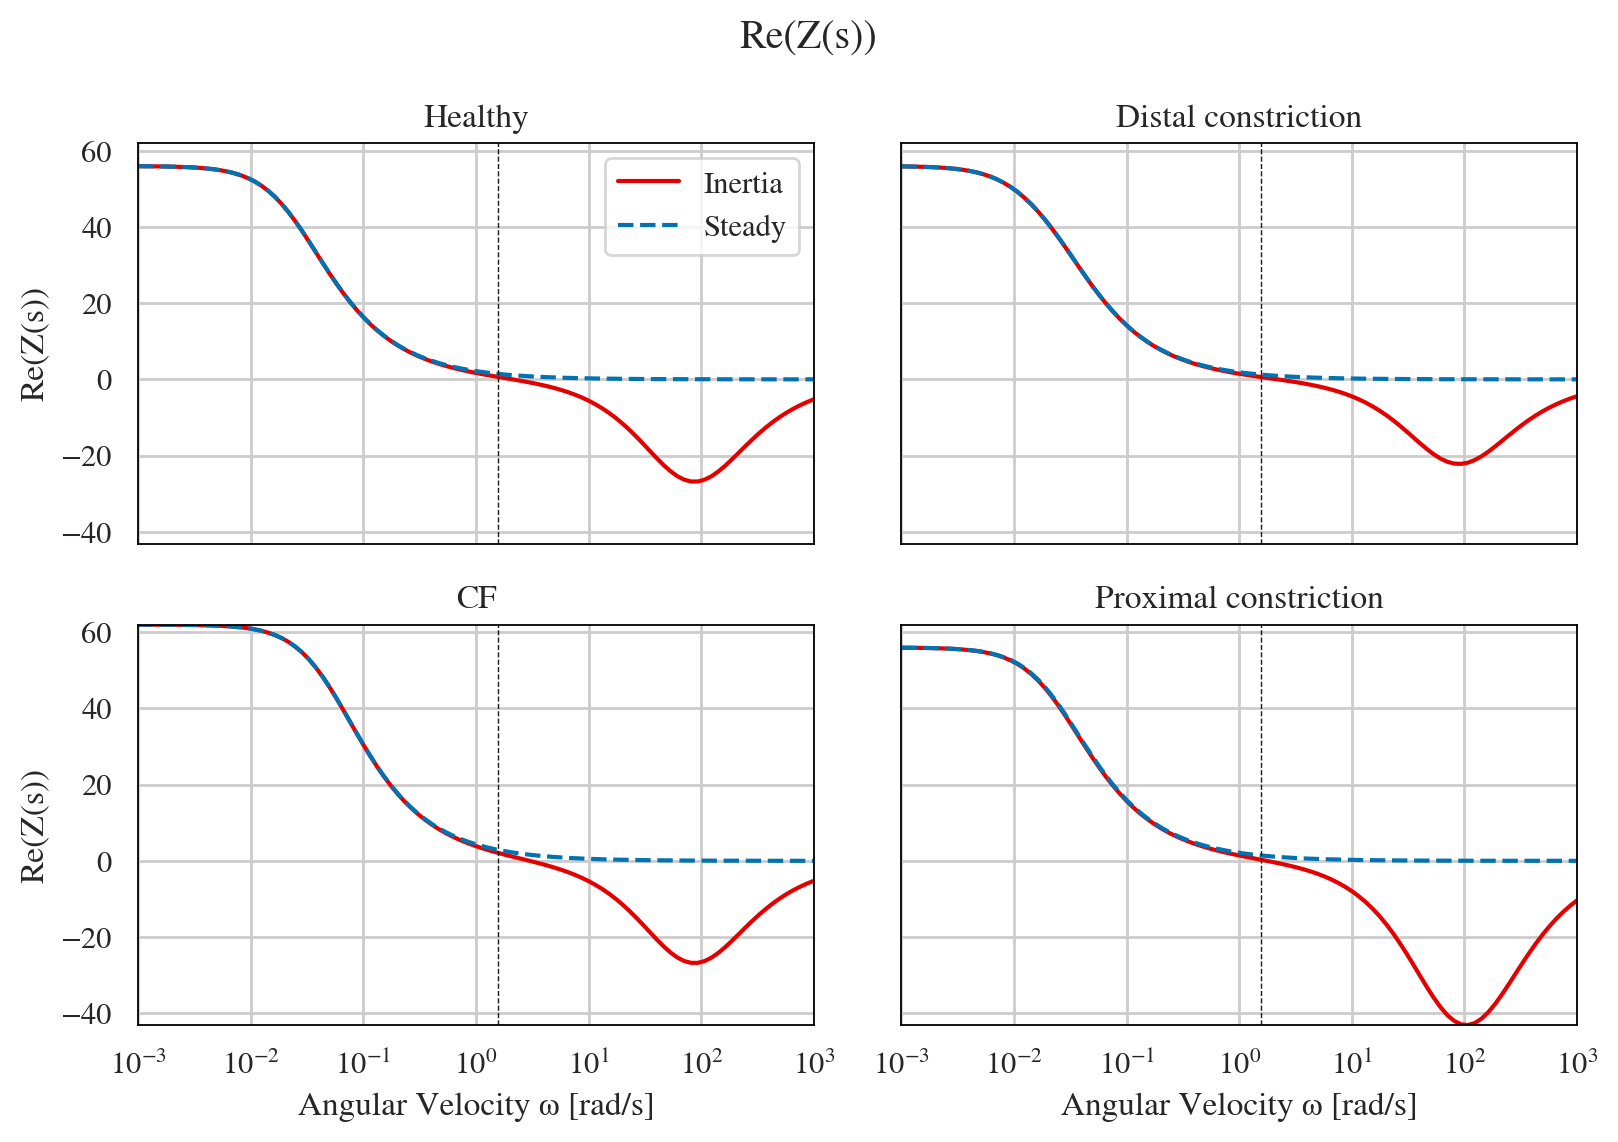

In [7]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax[0, 0].semilogx(w, real_inertia1, label="Inertia", color='#E50000')
ax[0, 0].semilogx(w, real_steady1, label="Steady", color="b", linestyle="--")
ax[0, 0].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[0, 0].set_title("Healthy")

ax[0, 1].semilogx(w, real_inertia2, label="Inertia", color='#E50000')
ax[0, 1].semilogx(w, real_steady2, label="Steady", color="b", linestyle="--")
ax[0, 1].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[0, 1].set_title("Distal constriction")

ax[1, 0].semilogx(w, real_inertia3, label="Inertia", color='#E50000')
ax[1, 0].semilogx(w, real_steady3, label="Steady", color="b", linestyle="--")
ax[1, 0].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[1, 0].set_title("CF")

ax[1, 1].semilogx(w, real_inertia4, label="Inertia", color='#E50000')
ax[1, 1].semilogx(w, real_steady4, label="Steady", color="b", linestyle="--")
ax[1, 1].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[1, 1].set_title("Proximal constriction")

ax[1, 0].set_xlabel("Angular Velocity ω [rad/s]")
ax[1, 1].set_xlabel("Angular Velocity ω [rad/s]")
ax[0, 0].set_ylabel("Re(Z(s))")
ax[1, 0].set_ylabel("Re(Z(s))")
ax[0, 0].legend()
plt.suptitle("Re(Z(s))")
plt.tight_layout()
plt.show()

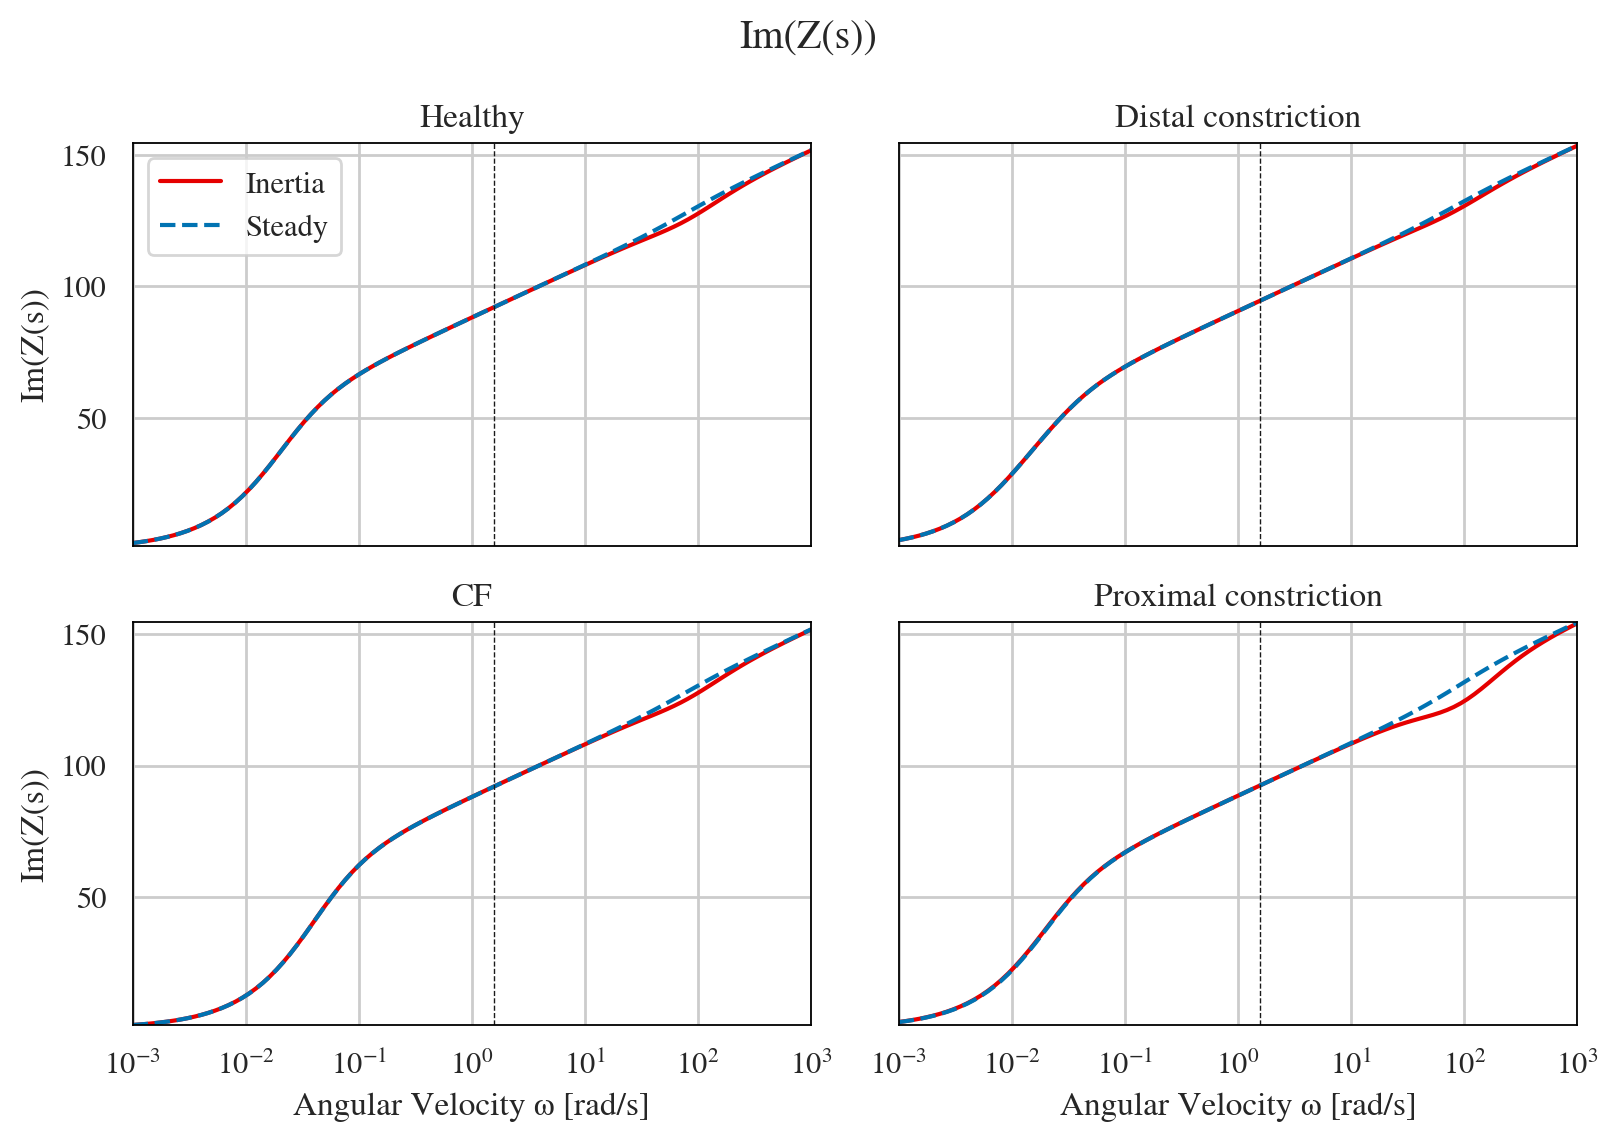

In [8]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax[0, 0].semilogx(w, imaginary_inertia1, label="Inertia", color='#E50000')
ax[0, 0].semilogx(w, imaginary_steady1, label="Steady", color="b", linestyle="--")
ax[0, 0].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[0, 0].set_title("Healthy")

ax[0, 1].semilogx(w, imaginary_inertia2, label="Inertia", color='#E50000')
ax[0, 1].semilogx(w, imaginary_steady2, label="Steady", color="b", linestyle="--")
ax[0, 1].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[0, 1].set_title("Distal constriction")

ax[1, 0].semilogx(w, imaginary_inertia3, label="Inertia", color='#E50000')
ax[1, 0].semilogx(w, imaginary_steady3, label="Steady", color="b", linestyle="--")
ax[1, 0].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[1, 0].set_title("CF")

ax[1, 1].semilogx(w, imaginary_inertia4, label="Inertia", color='#E50000')
ax[1, 1].semilogx(w, imaginary_steady4, label="Steady", color="b", linestyle="--")
ax[1, 1].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[1, 1].set_title("Proximal constriction")

ax[1, 0].set_xlabel("Angular Velocity ω [rad/s]")
ax[1, 1].set_xlabel("Angular Velocity ω [rad/s]")
ax[0, 0].set_ylabel("Im(Z(s))")
ax[1, 0].set_ylabel("Im(Z(s))")
ax[0, 0].legend()
plt.suptitle("Im(Z(s))")
plt.tight_layout()
plt.show()

In [9]:
inertia5 = BharatModel(D0=0.02, L0=0.1, h1L=2**(1/2), h2L=2**(1/2), h1D= 0.5*2**(1/4), h2D=2**(1/4), C1=1/1256, C2=1/1256, Rd1=50000, Rd2=50000, n=n, d=d) #check Schmidtt for C1 and C2
steady5 = BharatModel(D0=0.02, L0=0.1, h1L=2**(1/3), h2L=2**(1/3), h1D= 0.5*2**(1/3), h2D=2**(1/3), C1=inertia5.C1, C2=inertia5.C2, Rd1=inertia5.Rd1, Rd2=inertia5.Rd2, n=n, d=d, steady=True)

inertia6 = BharatModel(D0=0.02, L0=0.1, h1L=2**(1/2), h2L=2**(1/2), h1D= 2**(1/4), h2D=2**(1/4), C1=1/1256, C2=1/1256, Rd1=100000, Rd2=50000, n=n, d=d) #check Schmidtt for C1 and C2
steady6 = BharatModel(D0=0.02, L0=0.1, h1L=2**(1/3), h2L=2**(1/3), h1D= 2**(1/3), h2D=2**(1/3), C1=inertia6.C1, C2=inertia6.C2, Rd1=inertia6.Rd1, Rd2=inertia6.Rd2, n=n, d=d, steady=True)

inertia7 = BharatModel(D0=0.02, L0=0.1, h1L=2**(1/2), h2L=2**(1/2), h1D= 2**(1/4), h2D=0.5*2**(1/4), C1=1/1256, C2=1/1256, Rd1=50000, Rd2=50000, n=n, d=d) #check Schmidtt for C1 and C2
steady7 = BharatModel(D0=0.02, L0=0.1, h1L=2**(1/3), h2L=2**(1/3), h1D= 2**(1/3), h2D=0.5*2**(1/3), C1=inertia7.C1, C2=inertia7.C2, Rd1=inertia7.Rd1, Rd2=inertia7.Rd2, n=n, d=d, steady=True)

inertia8 = BharatModel(D0=0.02, L0=0.1, h1L=2**(1/2), h2L=2**(1/2), h1D= 2**(1/4), h2D=2**(1/4), C1=1/1256, C2=1/1256, Rd1=50000, Rd2=100000, n=n, d=d) #check Schmidtt for C1 and C2
steady8 = BharatModel(D0=0.02, L0=0.1, h1L=2**(1/3), h2L=2**(1/3), h1D= 2**(1/3), h2D=2**(1/3), C1=inertia8.C1, C2=inertia8.C2, Rd1=inertia8.Rd1, Rd2=inertia8.Rd2, n=n, d=d, steady=True)


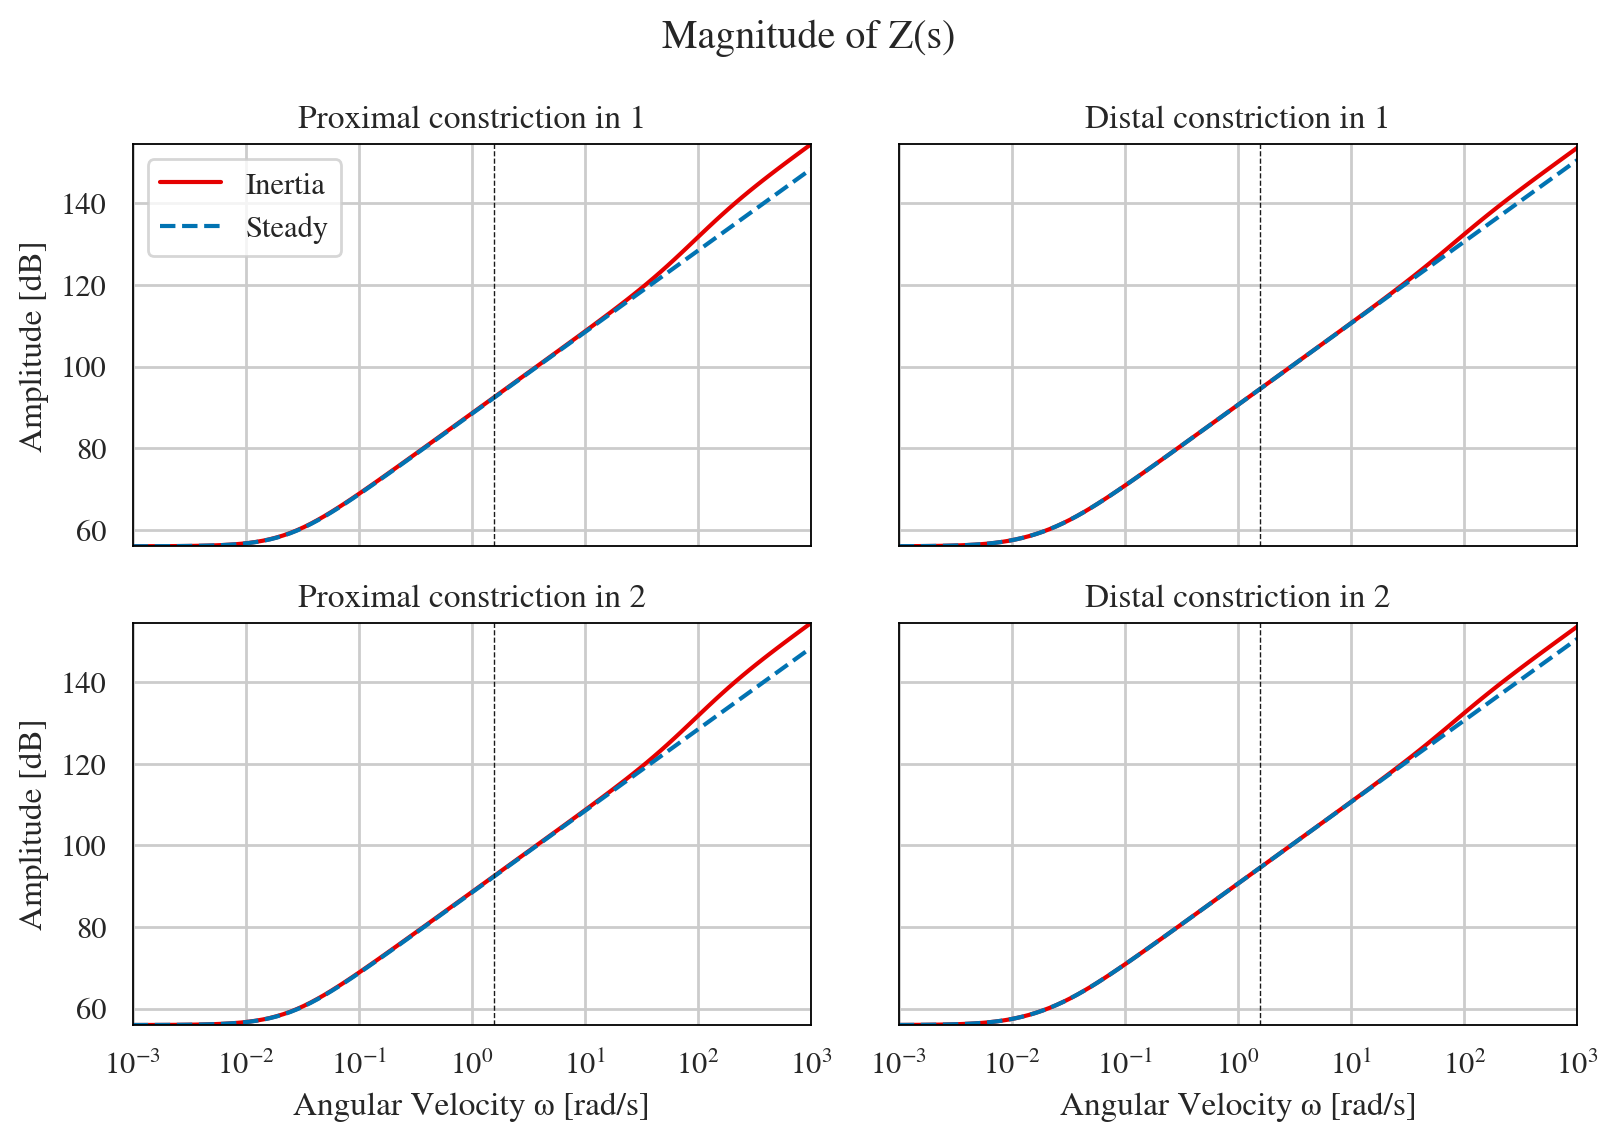

In [10]:
w, mag_inertia5, phase_inertia5 = inertia5.bode()
w, mag_steady5, phase_steady5 = steady5.bode(w=w)
w, mag_inertia6, phase_inertia6 = inertia6.bode(w=w)
w, mag_steady6, phase_steady6 = steady6.bode(w=w)
w, mag_inertia7, phase_inertia7 = inertia7.bode(w=w)
w, mag_steady7, phase_steady7 = steady7.bode(w=w)
w, mag_inertia8, phase_inertia8 = inertia8.bode(w=w)
w, mag_steady8, phase_steady8 = steady8.bode(w=w)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax[0, 0].semilogx(w, mag_inertia5, label="Inertia", color='#E50000')
ax[0, 0].semilogx(w, mag_steady5, label="Steady", color="b", linestyle="--")
ax[0, 0].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[0, 0].set_title("Proximal constriction in 1")

ax[0, 1].semilogx(w, mag_inertia6, label="Inertia", color='#E50000')
ax[0, 1].semilogx(w, mag_steady6, label="Steady", color="b", linestyle="--")
ax[0, 1].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[0, 1].set_title("Distal constriction in 1")

ax[1, 0].semilogx(w, mag_inertia7, label="Inertia", color='#E50000')
ax[1, 0].semilogx(w, mag_steady7, label="Steady", color="b", linestyle="--")
ax[1, 0].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[1, 0].set_title("Proximal constriction in 2")

ax[1, 1].semilogx(w, mag_inertia8, label="Inertia", color='#E50000')
ax[1, 1].semilogx(w, mag_steady8, label="Steady", color="b", linestyle="--")
ax[1, 1].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[1, 1].set_title("Distal constriction in 2")

ax[1, 0].set_xlabel("Angular Velocity ω [rad/s]")
ax[1, 1].set_xlabel("Angular Velocity ω [rad/s]")
ax[0, 0].set_ylabel("Amplitude [dB]")
ax[1, 0].set_ylabel("Amplitude [dB]")
ax[0,0].legend()
plt.suptitle("Magnitude of Z(s)")
plt.tight_layout()
plt.show()

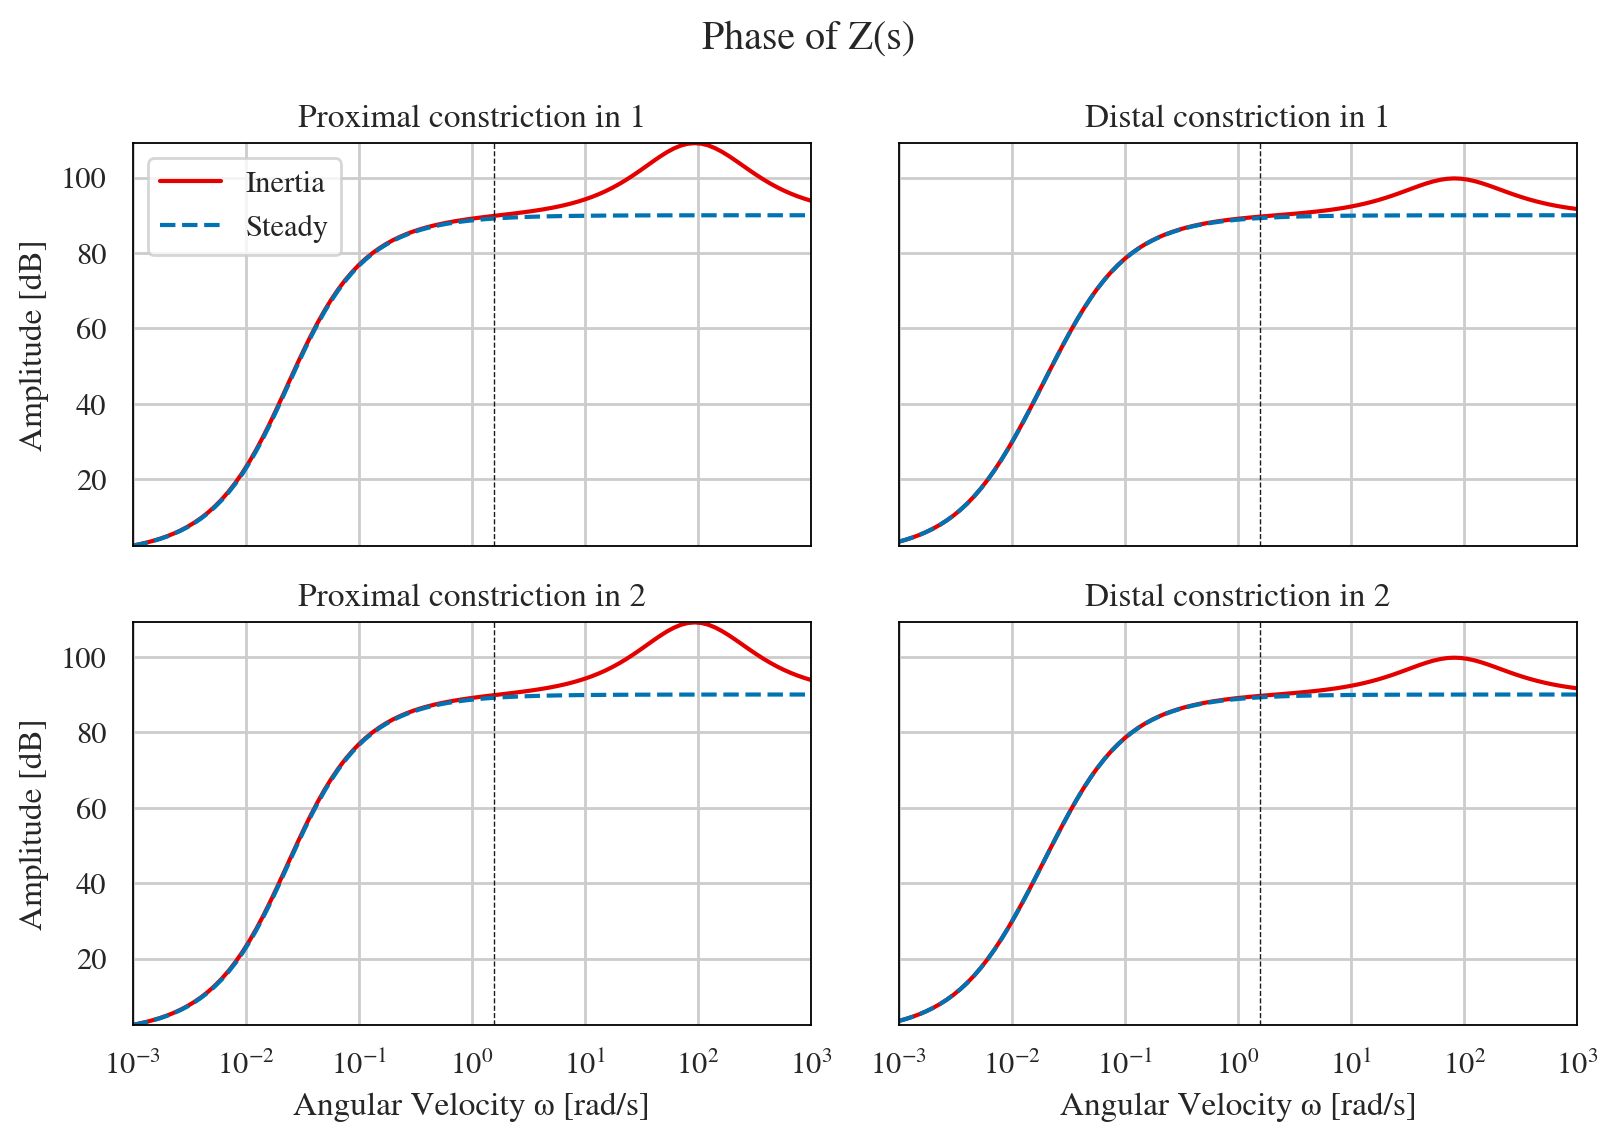

In [11]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax[0, 0].semilogx(w, phase_inertia5, label="Inertia", color='#E50000')
ax[0, 0].semilogx(w, phase_steady5, label="Steady", color="b", linestyle="--")
ax[0, 0].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[0, 0].set_title("Proximal constriction in 1")

ax[0, 1].semilogx(w, phase_inertia6, label="Inertia", color='#E50000')
ax[0, 1].semilogx(w, phase_steady6, label="Steady", color="b", linestyle="--")
ax[0, 1].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[0, 1].set_title("Distal constriction in 1")

ax[1, 0].semilogx(w, phase_inertia7, label="Inertia", color='#E50000')
ax[1, 0].semilogx(w, phase_steady7, label="Steady", color="b", linestyle="--")
ax[1, 0].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[1, 0].set_title("Proximal constriction in 2")

ax[1, 1].semilogx(w, phase_inertia8, label="Inertia", color='#E50000')
ax[1, 1].semilogx(w, phase_steady8, label="Steady", color="b", linestyle="--")
ax[1, 1].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[1, 1].set_title("Distal constriction in 2")

ax[1, 0].set_xlabel("Angular Velocity ω [rad/s]")
ax[1, 1].set_xlabel("Angular Velocity ω [rad/s]")
ax[0, 0].set_ylabel("Amplitude [dB]")
ax[1, 0].set_ylabel("Amplitude [dB]")
ax[0,0].legend()
plt.suptitle("Phase of Z(s)")
plt.tight_layout()
plt.show()

# Simulating newborn lungs
In newborn lungs the elastance of the parenchyma changes substantially. In Schmidt et al. the typical values of compliance for newborn lungs are around e-9 Pa. This is a major change that should be reflected in the overall impedance of the lungs. By adopting the values in his paper, using our model:

In [12]:
newborn_inertia = BharatModel(D0=0.02, L0=0.1, h1L=2**(1/2), h2L=2**(1/2), h1D= 0.5*2**(1/4), h2D=2**(1/4), C1=15e-6, C2=15e-6, Rd1=50000, Rd2=50000, n=n, d=d)
newborn_steady = BharatModel(D0=0.02, L0=0.1, h1L=2**(1/2), h2L=2**(1/2), h1D= 0.5*2**(1/4), h2D=2**(1/4), C1=15e-6, C2=15e-6, Rd1=50000, Rd2=50000, n=n, d=d, steady=True)

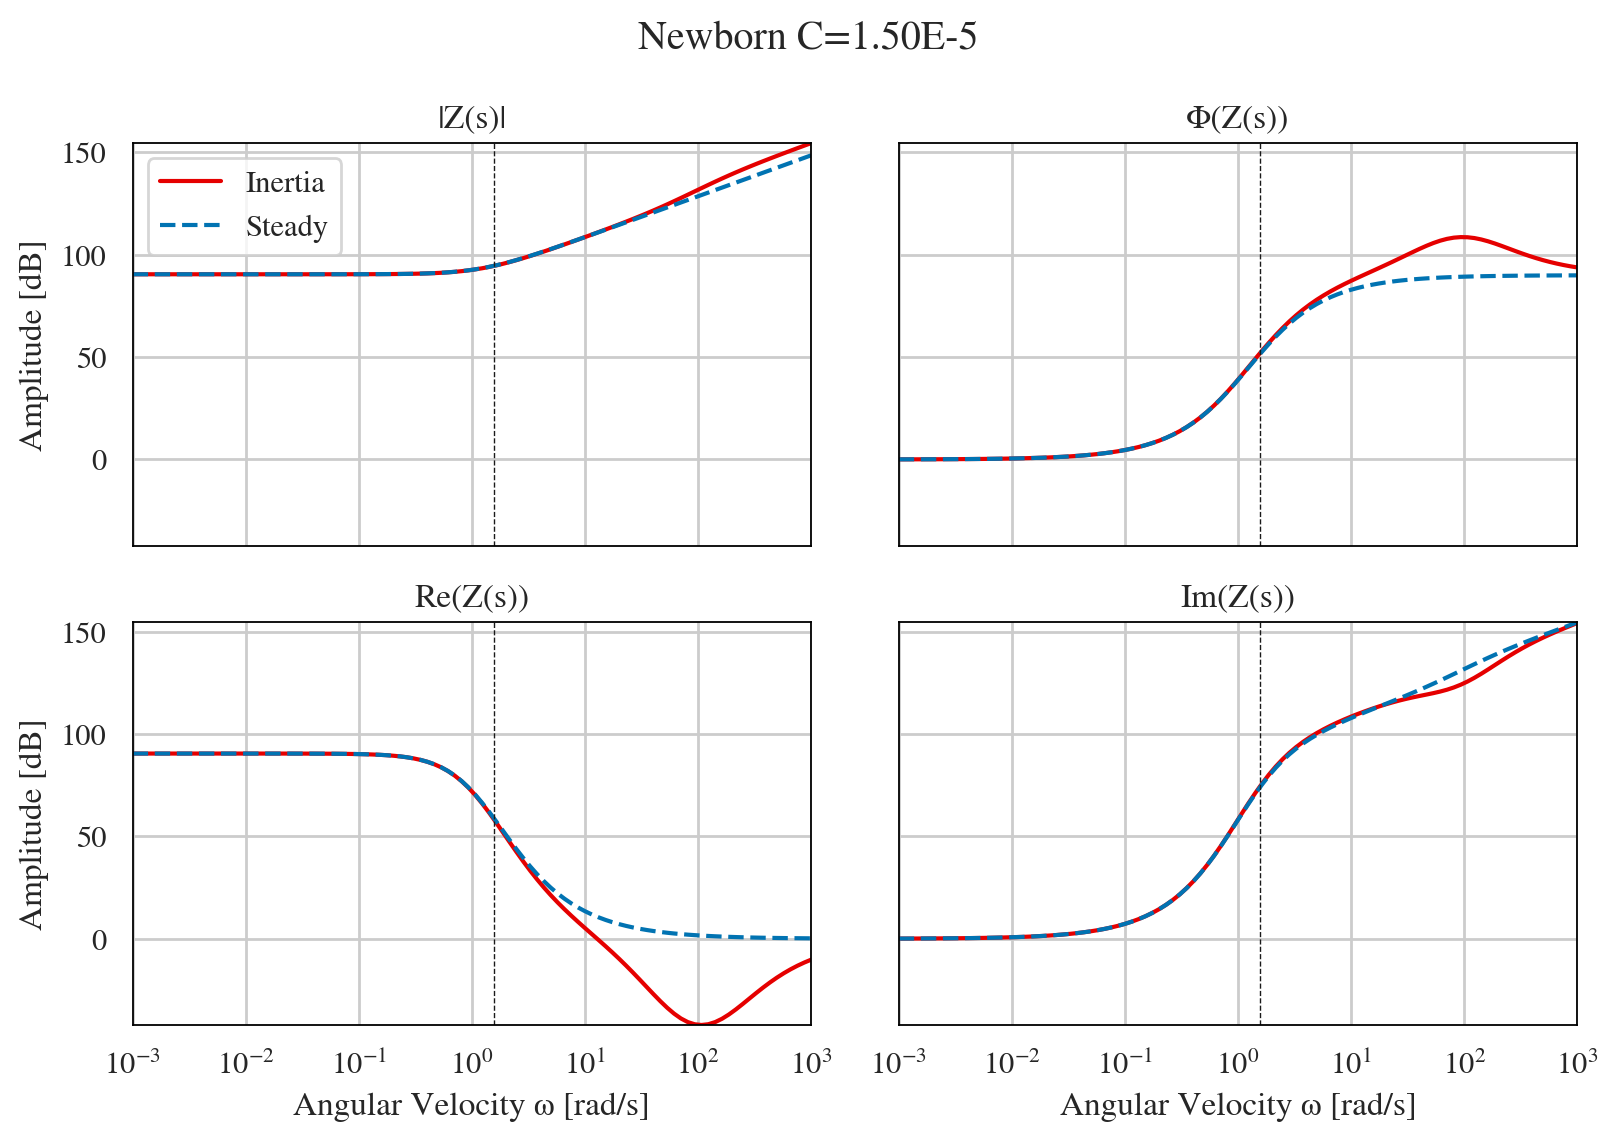

In [13]:
w, mag_inertia9, phase_inertia9 = newborn_inertia.bode(w=w)
w, mag_steady9, phase_steady9 = newborn_steady.bode(w=w)
real_inertia9 = mag_inertia9 * np.cos(np.deg2rad(phase_inertia9))
imaginary_inertia9 = mag_inertia9 * np.sin(np.deg2rad(phase_inertia9))
real_steady9 = mag_inertia9 * np.cos(np.deg2rad(phase_steady9))
imaginary_steady9 = mag_inertia9 * np.sin(np.deg2rad(phase_steady9))

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax[0,0].semilogx(w, mag_inertia9, label="Inertia", color='#E50000')
ax[0,0].semilogx(w, mag_steady9, label="Steady", color="b", linestyle="--")
ax[0,0].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[0,0].set_title("|Z(s)|")

ax[0,1].semilogx(w, phase_inertia9, label="Inertia", color='#E50000')
ax[0,1].semilogx(w, phase_steady9, label="Steady", color="b", linestyle="--")
ax[0,1].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[0,1].set_title("Φ(Z(s))")

ax[1,0].semilogx(w, real_inertia9, label="Inertia", color='#E50000')
ax[1,0].semilogx(w, real_steady9, label="Steady", color="b", linestyle="--")
ax[1,0].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[1,0].set_title("Re(Z(s))")

ax[1,1].semilogx(w, imaginary_inertia9, label="Inertia", color='#E50000')
ax[1,1].semilogx(w, imaginary_steady9, label="Steady", color="b", linestyle="--")
ax[1,1].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[1,1].set_title("Im(Z(s))")

ax[1, 0].set_xlabel("Angular Velocity ω [rad/s]")
ax[1, 1].set_xlabel("Angular Velocity ω [rad/s]")
ax[0, 0].set_ylabel("Amplitude [dB]")
ax[1, 0].set_ylabel("Amplitude [dB]")
ax[0,0].legend()
plt.suptitle(f"Newborn C={Decimal(newborn_inertia.C1):.2E}")
plt.tight_layout()
plt.show()

## Simulating with $R_d$=0

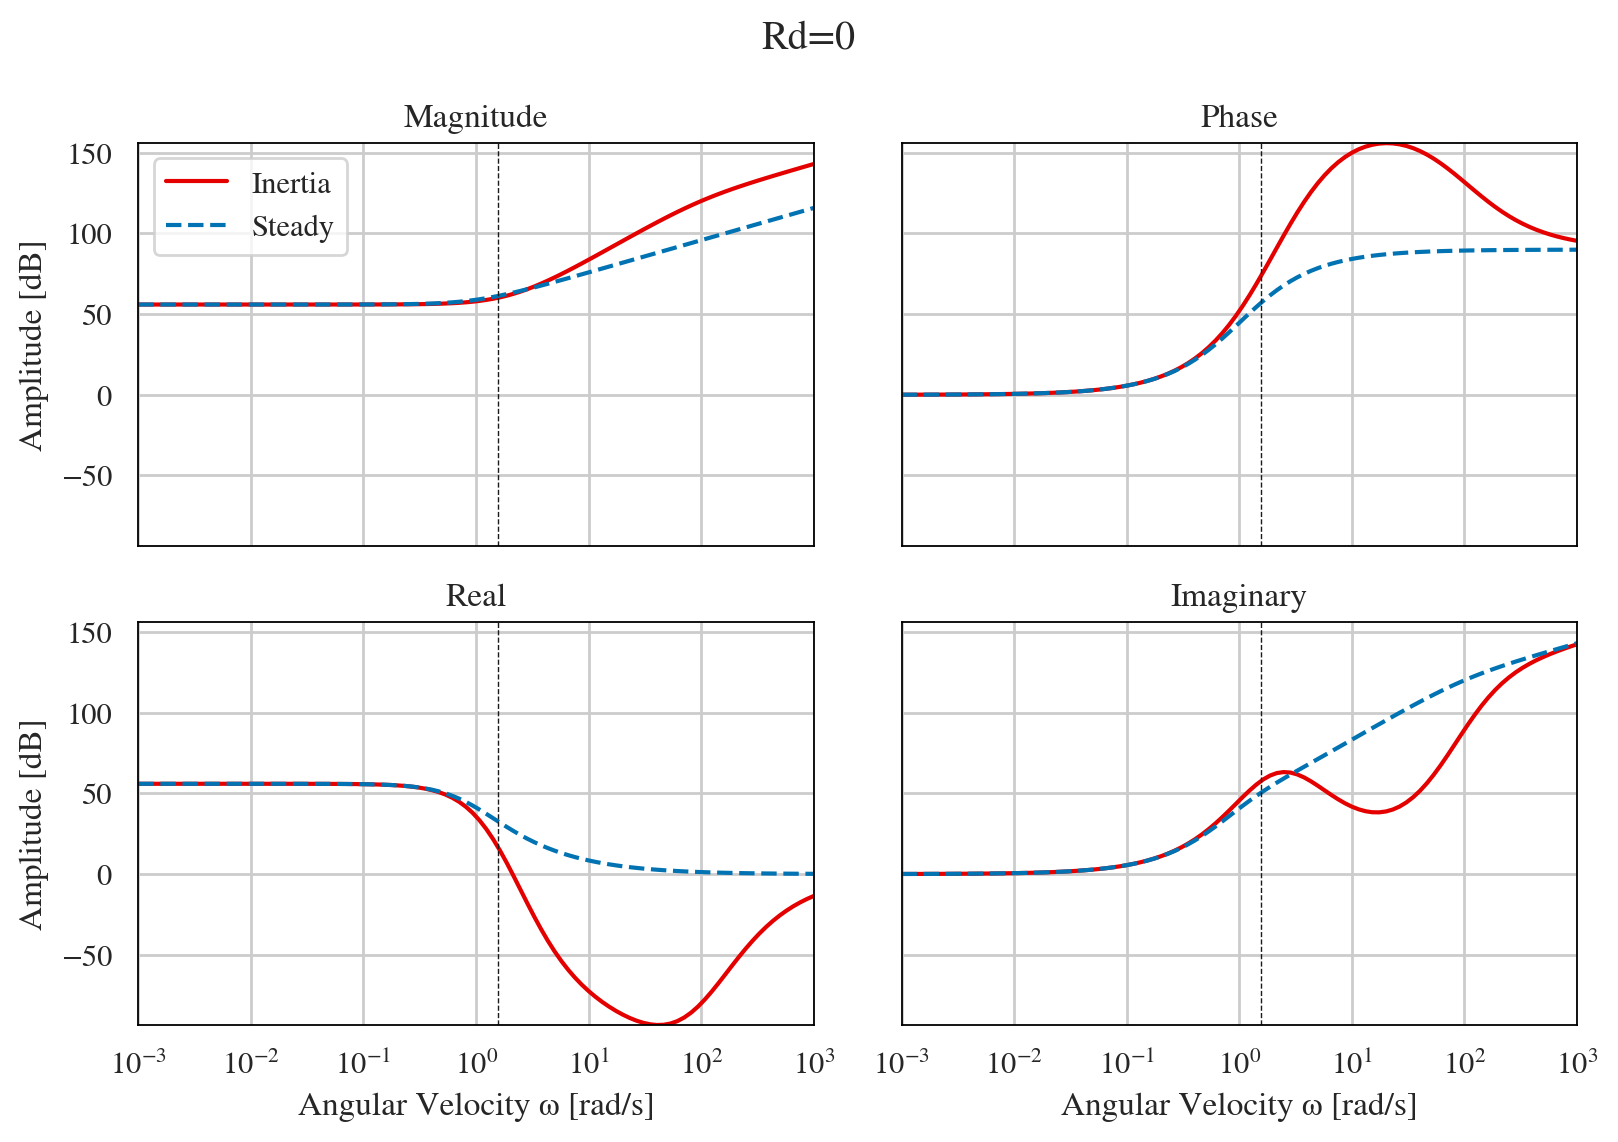

In [14]:
inertia0 = BharatModel(D0=0.02, L0=0.1, h1L=2**(1/2), h2L=2**(1/2), h1D= 2**(1/4), h2D=2**(1/4), C1=1/1256, C2=1/1256, Rd1=0, Rd2=0, n=n, d=d)
steady0 = BharatModel(D0=0.02, L0=0.1, h1L=2**(1/2), h2L=2**(1/2), h1D= 2**(1/4), h2D=2**(1/4), C1=1/1256, C2=1/1256, Rd1=0, Rd2=0, n=n, d=d, steady=True)
w, mag_inertia0, phase_inertia0 = inertia0.bode(w=w)
w, mag_steady0, phase_steady0 = steady0.bode(w=w)
real_inertia0 = mag_inertia0 * np.cos(np.deg2rad(phase_inertia0))
imaginary_inertia0 = mag_inertia0 * np.sin(np.deg2rad(phase_inertia0))
real_steady0 = mag_inertia0 * np.cos(np.deg2rad(phase_steady0))
imaginary_steady0 = mag_inertia0 * np.sin(np.deg2rad(phase_steady0))


fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax[0,0].semilogx(w, mag_inertia0, label="Inertia", color='#E50000')
ax[0,0].semilogx(w, mag_steady0, label="Steady", color="b", linestyle="--")
ax[0,0].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[0,0].set_title("Magnitude")

ax[0,1].semilogx(w, phase_inertia0, label="Inertia", color='#E50000')
ax[0,1].semilogx(w, phase_steady0, label="Steady", color="b", linestyle="--")
ax[0,1].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[0,1].set_title("Phase")

ax[1,0].semilogx(w, real_inertia0, label="Inertia", color='#E50000')
ax[1,0].semilogx(w, real_steady0, label="Steady", color="b", linestyle="--")
ax[1,0].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[1,0].set_title("Real")

ax[1,1].semilogx(w, imaginary_inertia0, label="Inertia", color='#E50000')
ax[1,1].semilogx(w, imaginary_steady0, label="Steady", color="b", linestyle="--")
ax[1,1].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[1,1].set_title("Imaginary")

ax[1, 0].set_xlabel("Angular Velocity ω [rad/s]")
ax[1, 1].set_xlabel("Angular Velocity ω [rad/s]")
ax[0, 0].set_ylabel("Amplitude [dB]")
ax[1, 0].set_ylabel("Amplitude [dB]")
ax[0,0].legend()
plt.suptitle("Rd=0")
plt.tight_layout()
plt.show()

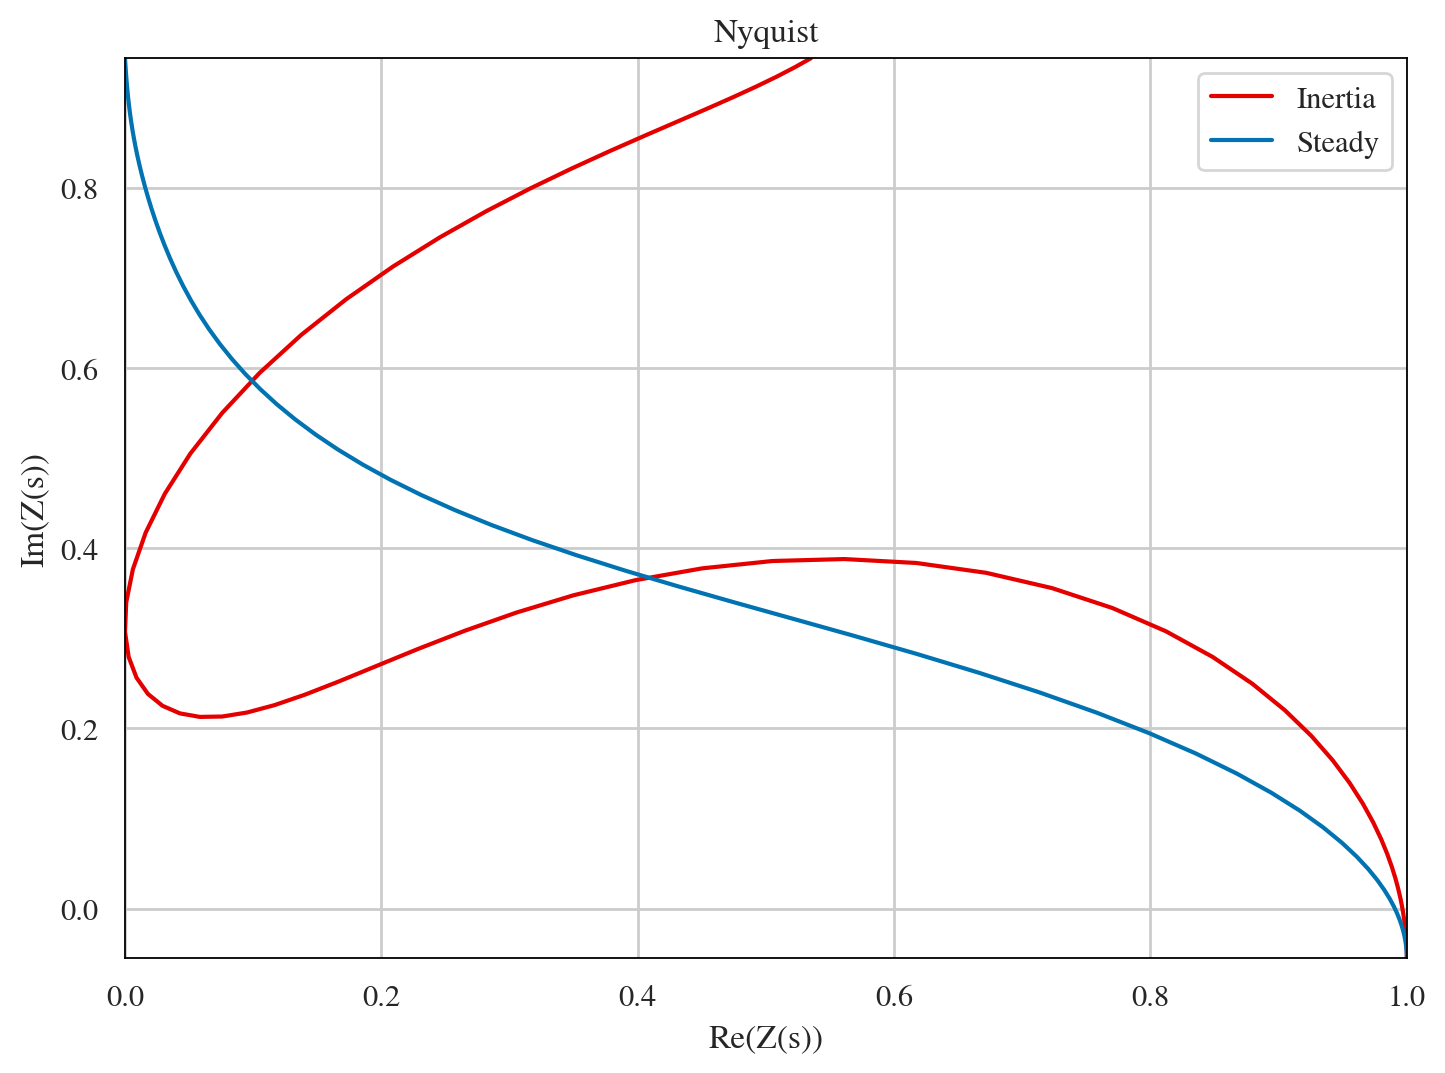

In [15]:
plt.figure()
plt.plot((real_inertia0-min(real_inertia0))/(max(real_inertia0)-min(real_inertia0)), (imaginary_inertia0-min(imaginary_inertia0))/max(imaginary_inertia0)-min(imaginary_inertia0), label="Inertia", color="#E50000")
plt.plot((real_steady0-min(real_steady0))/(max(real_steady0)-min(real_steady0)), (imaginary_steady0-min(imaginary_steady0))/max(imaginary_steady0)-min(imaginary_steady0), label="Steady", color="b")
plt.legend()
plt.xlabel("Re(Z(s))")
plt.ylabel("Im(Z(s))")
plt.title("Nyquist")
plt.show()

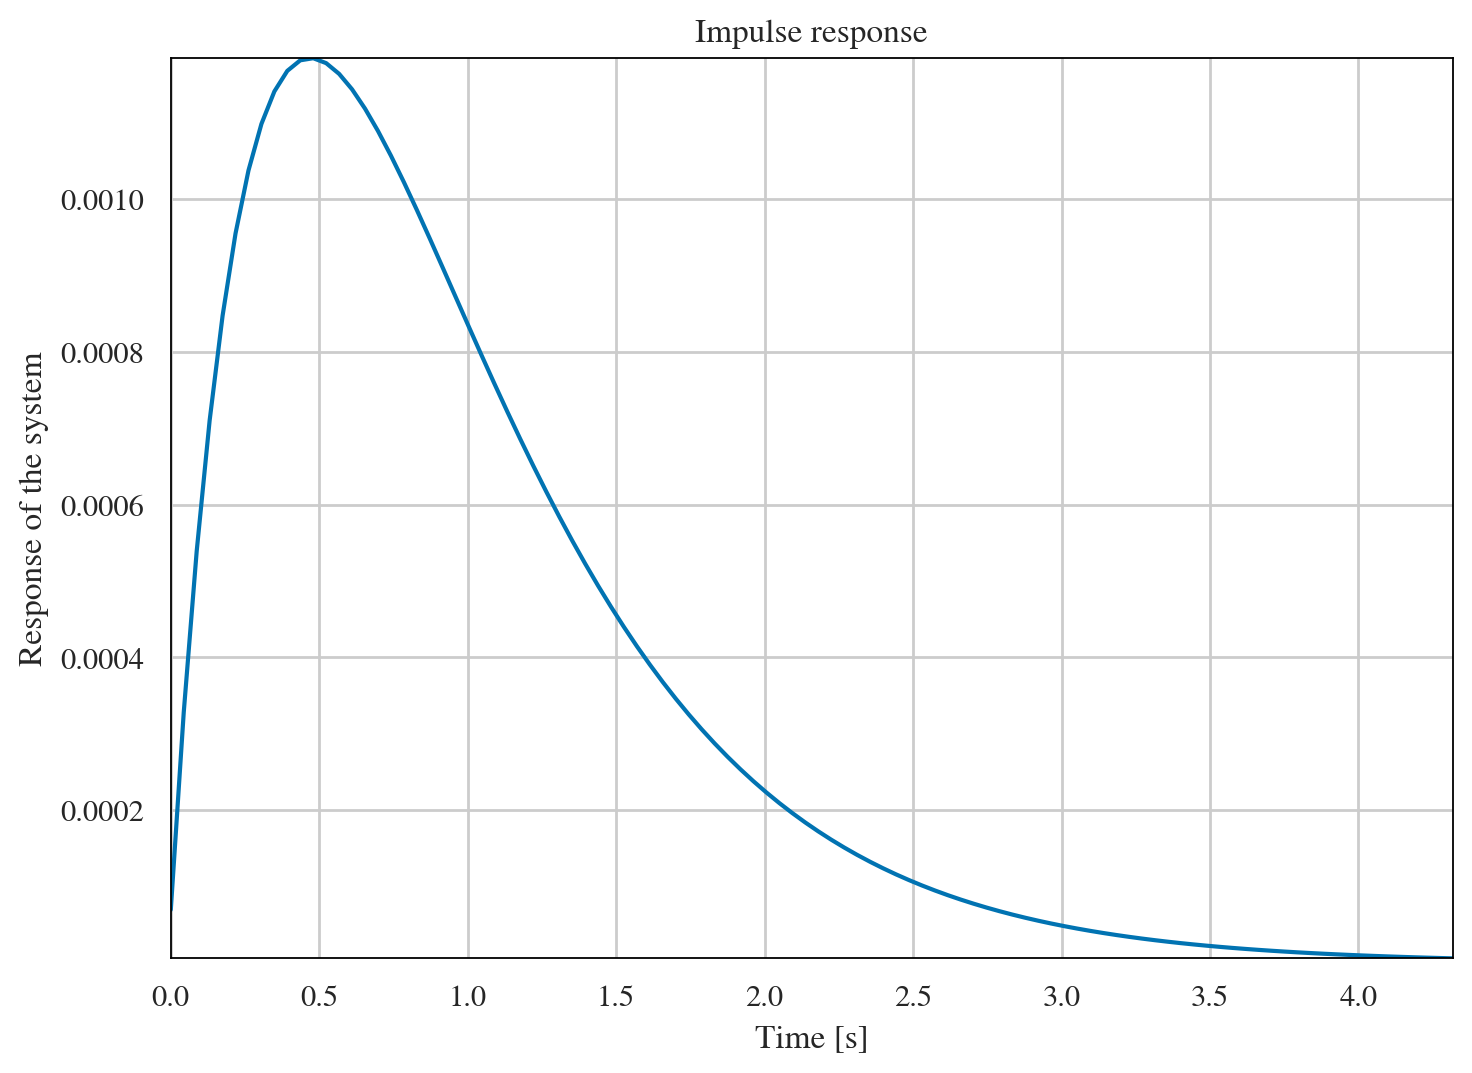

In [16]:
inertia0 = BharatModel(impedance=False, D0=0.02, L0=0.1, h1L=2**(1/2), h2L=2**(1/2), h1D= 2**(1/4), h2D=2**(1/4), C1=1/1256, C2=1/1256, Rd1=0, Rd2=0, n=n, d=d)
t,y = inertia0.impulse()
plt.plot(t, y)
plt.xlabel("Time [s]")
plt.ylabel("Response of the system")
plt.title("Impulse response")
plt.show()

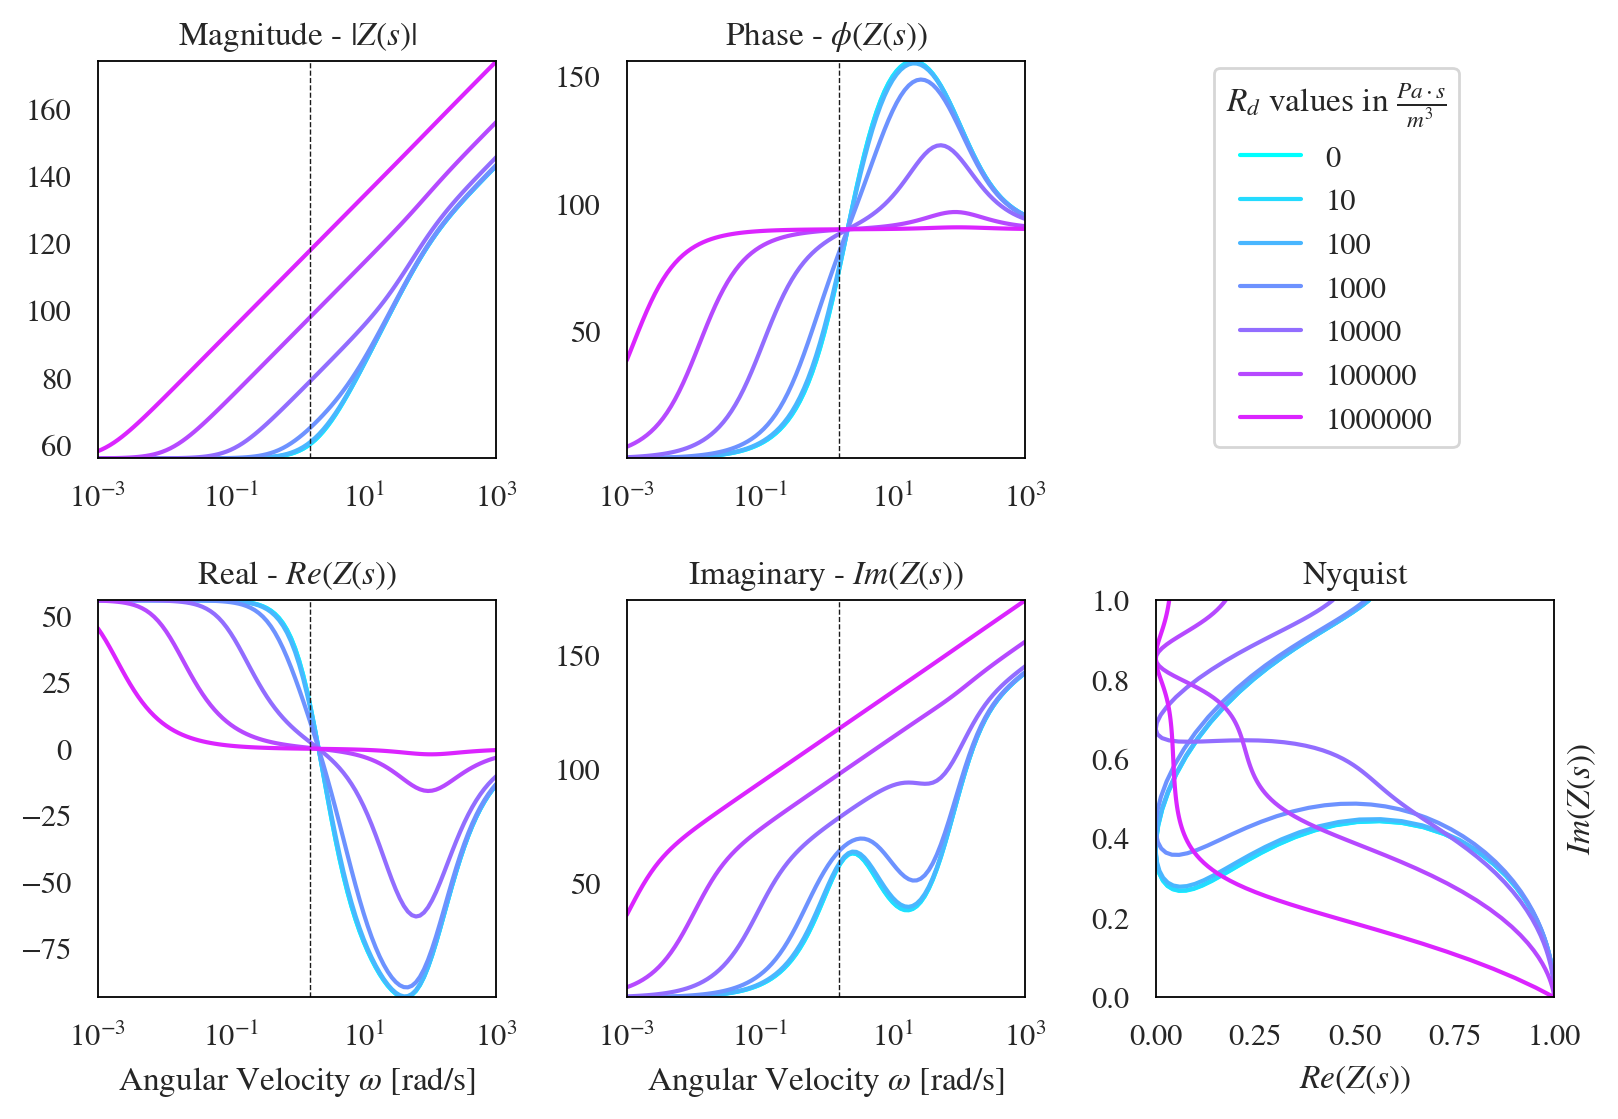

In [19]:
import matplotlib

cmap = matplotlib.cm.get_cmap('cool')
Rd_list = [0, 10, 100, 1000, 10000, 100000, 1000000]
colors = [cmap(i/len(Rd_list)) for i in range(len(Rd_list))]
matplotlib.rcParams['axes.grid'] = False
fig, ax = plt.subplots(2, 3)
for Rd, c in zip(Rd_list, colors):
    model = BharatModel(D0=0.02, L0=0.1, h1L=2**(1/2), h2L=2**(1/2), h1D= 2**(1/4), h2D=2**(1/4), C1=1/1256, C2=1/1256, Rd1=Rd, Rd2=Rd, n=n, d=d)
    w, mag_model, phase_model = model.bode(w=w)
    real_model = mag_model * np.cos(np.deg2rad(phase_model))
    imaginary_model = mag_model * np.sin(np.deg2rad(phase_model))

    ax[0,0].semilogx(w, mag_model, label=f"Rd = {Rd}", color=c)
    ax[0,1].semilogx(w, phase_model, label=f"Rd = {Rd}", color=c)
    ax[1,0].semilogx(w, real_model, label=f"Rd = {Rd}", color=c)
    ax[1,1].semilogx(w, imaginary_model, label=f"Rd = {Rd}", color=c)
    ax[1,2].plot((real_model-min(real_model))/(max(real_model)-min(real_model)), (imaginary_model-min(imaginary_model))/(max(imaginary_model)-min(imaginary_model)),color=c)
    
ax[0,0].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[0,1].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[1,0].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[1,1].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[0,0].set_title(r"Magnitude - $|Z(s)|$")
ax[0,1].set_title(r"Phase - $\phi(Z(s))$")
ax[1,0].set_title(r"Real - $Re(Z(s))$")
ax[1,1].set_title(r"Imaginary - $Im(Z(s))$")
ax[1,2].set_title(r"Nyquist")
ax[1, 0].set_xlabel(r"Angular Velocity $\omega$ [rad/s]")
ax[1, 1].set_xlabel(r"Angular Velocity $\omega$ [rad/s]")

ax[1, 2].set_xlabel(r"$Re(Z(s))$")
ax[1, 2].set_ylabel(r"$Im(Z(s))$")
ax[1, 2].yaxis.set_label_position("right")
ax[0,1].sharex(ax[0,0])
ax[1,1].sharex(ax[0,0])
ax[1,0].sharex(ax[0,0])

fig.legend(loc = (0.75, 0.6), labels={rd:c for rd,c in zip(Rd_list,colors)}, title=r"$R_d$ values in $\frac{Pa\cdot s}{m^3}$")
fig.delaxes(ax[0, 2])
plt.tight_layout()
#plt.savefig("Rd_in_BharatModel_steady.pdf")

## Compliance parameter
Let's observe the effect of changing the compliance in such model, for the moment the 2 compliances will be changed together.

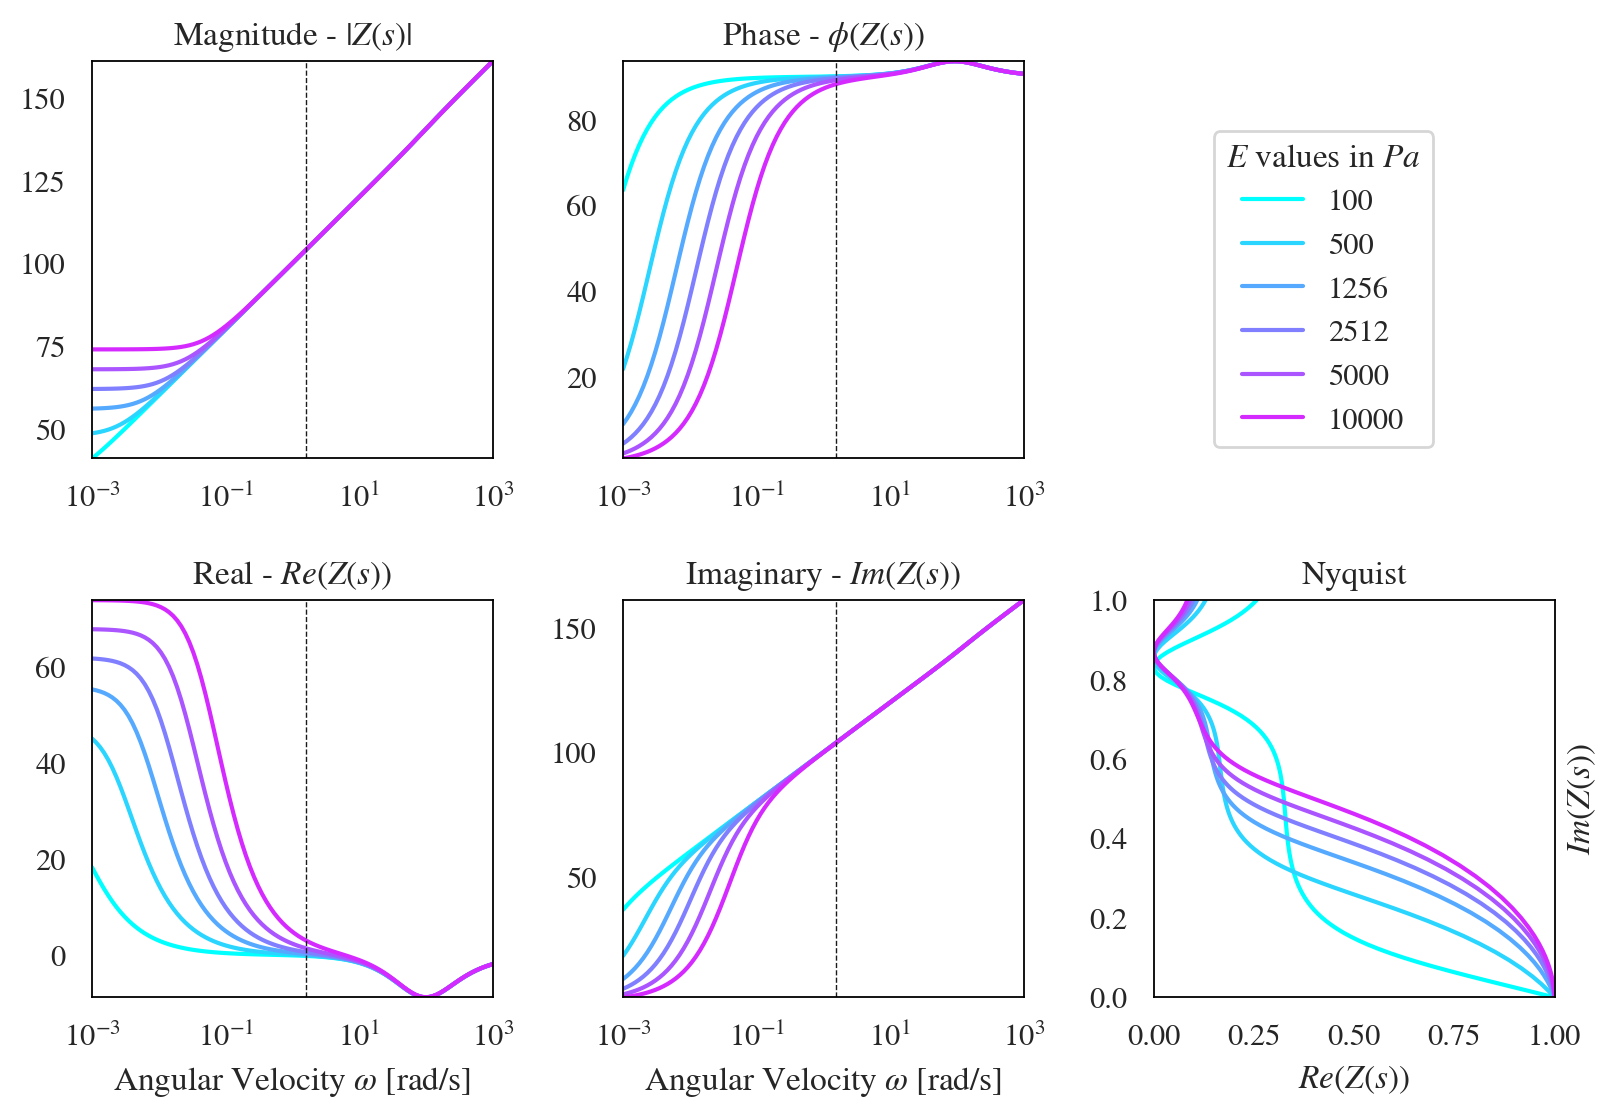

In [27]:
import matplotlib

cmap = matplotlib.cm.get_cmap('cool')
C_list = [100, 500, 1256, 2512, 5000, 10000]
colors = [cmap(i/len(C_list)) for i in range(len(C_list))]
matplotlib.rcParams['axes.grid'] = False
fig, ax = plt.subplots(2, 3)
for C, c in zip(C_list, colors):
    model = BharatModel(D0=0.02, L0=0.1, h1L=2**(1/2), h2L=2**(1/2), h1D= 2**(1/4), h2D=2**(1/4), C1=1/C, C2=1/C, Rd1=200000, Rd2=200000, n=n, d=d)
    w, mag_model, phase_model = model.bode(w=w)
    real_model = mag_model * np.cos(np.deg2rad(phase_model))
    imaginary_model = mag_model * np.sin(np.deg2rad(phase_model))

    ax[0,0].semilogx(w, mag_model, label=f"C = {C}", color=c)
    ax[0,1].semilogx(w, phase_model, label=f"C = {C}", color=c)
    ax[1,0].semilogx(w, real_model, label=f"C = {C}", color=c)
    ax[1,1].semilogx(w, imaginary_model, label=f"C = {C}", color=c)
    ax[1,2].plot((real_model-min(real_model))/(max(real_model)-min(real_model)), (imaginary_model-min(imaginary_model))/(max(imaginary_model)-min(imaginary_model)),color=c)
    
ax[0,0].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[0,1].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[1,0].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[1,1].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[0,0].set_title(r"Magnitude - $|Z(s)|$")
ax[0,1].set_title(r"Phase - $\phi(Z(s))$")
ax[1,0].set_title(r"Real - $Re(Z(s))$")
ax[1,1].set_title(r"Imaginary - $Im(Z(s))$")
ax[1,2].set_title(r"Nyquist")
ax[1, 0].set_xlabel(r"Angular Velocity $\omega$ [rad/s]")
ax[1, 1].set_xlabel(r"Angular Velocity $\omega$ [rad/s]")

ax[1, 2].set_xlabel(r"$Re(Z(s))$")
ax[1, 2].set_ylabel(r"$Im(Z(s))$")
ax[1, 2].yaxis.set_label_position("right")
ax[0,1].sharex(ax[0,0])
ax[1,1].sharex(ax[0,0])
ax[1,0].sharex(ax[0,0])

fig.legend(loc = (0.75, 0.6), labels={C:c for C,c in zip(C_list,colors)}, title=r"$E$ values in $Pa$")
fig.delaxes(ax[0, 2])
plt.tight_layout()
plt.savefig("Elastance_in_BharatModel.pdf")

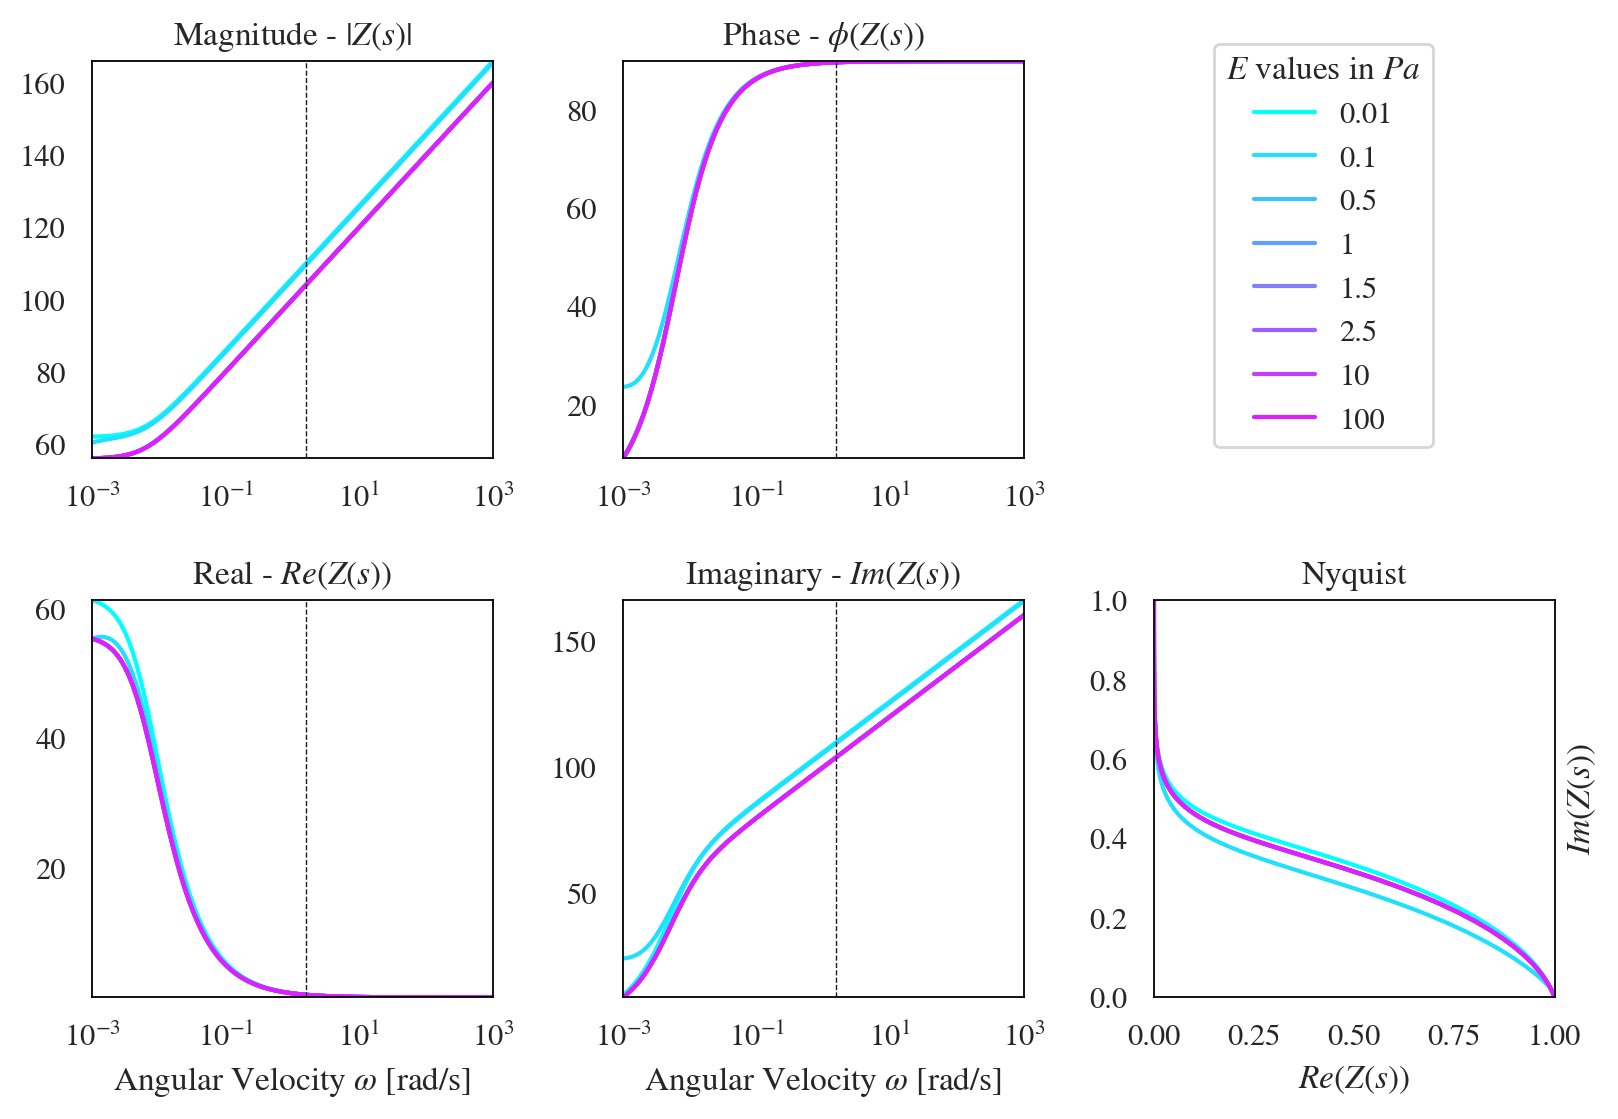

In [28]:
import matplotlib

cmap = matplotlib.cm.get_cmap('cool')
h1D_list = [0.01, 0.1, 0.5, 1, 1.5, 2.5, 10, 100]
colors = [cmap(i/len(h1D_list)) for i in range(len(h1D_list))]
matplotlib.rcParams['axes.grid'] = False
fig, ax = plt.subplots(2, 3)
for D1_constr, c in zip(h1D_list, colors):
    model = BharatModel(D0=0.02, L0=0.1, h1L=2**(1/2), h2L=2**(1/2), h1D= 2**(1/4)*D1_constr, h2D=2**(1/4), C1=1/1256, C2=1/1256, Rd1=200000, Rd2=200000, n=n, d=d, steady=True)
    w, mag_model, phase_model = model.bode(w=w)
    real_model = mag_model * np.cos(np.deg2rad(phase_model))
    imaginary_model = mag_model * np.sin(np.deg2rad(phase_model))

    ax[0,0].semilogx(w, mag_model, label=f"D1_constr = {D1_constr}", color=c)
    ax[0,1].semilogx(w, phase_model, label=f"D1_constr = {D1_constr}", color=c)
    ax[1,0].semilogx(w, real_model, label=f"D1_constr = {D1_constr}", color=c)
    ax[1,1].semilogx(w, imaginary_model, label=f"D1_constr = {D1_constr}", color=c)
    ax[1,2].plot((real_model-min(real_model))/(max(real_model)-min(real_model)), (imaginary_model-min(imaginary_model))/(max(imaginary_model)-min(imaginary_model)),color=c)
    
ax[0,0].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[0,1].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[1,0].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[1,1].axvline(2*np.pi*0.25, linewidth=0.5, linestyle='--', color='k')
ax[0,0].set_title(r"Magnitude - $|Z(s)|$")
ax[0,1].set_title(r"Phase - $\phi(Z(s))$")
ax[1,0].set_title(r"Real - $Re(Z(s))$")
ax[1,1].set_title(r"Imaginary - $Im(Z(s))$")
ax[1,2].set_title(r"Nyquist")
ax[1, 0].set_xlabel(r"Angular Velocity $\omega$ [rad/s]")
ax[1, 1].set_xlabel(r"Angular Velocity $\omega$ [rad/s]")

ax[1, 2].set_xlabel(r"$Re(Z(s))$")
ax[1, 2].set_ylabel(r"$Im(Z(s))$")
ax[1, 2].yaxis.set_label_position("right")
ax[0,1].sharex(ax[0,0])
ax[1,1].sharex(ax[0,0])
ax[1,0].sharex(ax[0,0])

fig.legend(loc = (0.75, 0.6), labels={D1_constr:c for D1_constr,c in zip(h1D_list,colors)}, title=r"$E$ values in $Pa$")
fig.delaxes(ax[0, 2])
plt.tight_layout()
# plt.savefig("Elastance_in_BharatModel.pdf")